# TTC Delay Data

In [1]:
!pip install geopandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import os
import seaborn as sns
from datetime import datetime as dt

1. import data

In [2]:
# Find all ttc subway ridership data file from the path
filenames = [file for file in os.listdir("TTC_delay") if ('ttc-subway-delay' in file) and (not 'readme' in file) and (not 'codes' in file)]
filenames

['ttc-subway-delay-data-2018.xlsx',
 'ttc-subway-delay-data-2019.xlsx',
 'ttc-subway-delay-data-2020.xlsx',
 'ttc-subway-delay-data-2021.xlsx',
 'ttc-subway-delay-data-2022.xlsx',
 'ttc-subway-delay-data-2023.xlsx',
 'ttc-subway-delay-jan-2014-april-2017.xlsx',
 'ttc-subway-delay-may-december-2017.xlsx']

In [3]:
def combine_excel_sheets(filenames, folder_path):
    all_dataframes = []

    # Read through all sheets of Excel file and combine as a dataframe
    for file in filenames:
        try:
            # Read the Excel file
            xls = pd.ExcelFile(os.path.join(folder_path, file))
            # Get all sheets names
            sheet_names = xls.sheet_names

            # Combine all dataframes
            combined_df = pd.concat([xls.parse(sheet_name) for sheet_name in sheet_names], ignore_index = True)

            # Append the combined dataframe to the list
            all_dataframes.append(combined_df)

        # If there are any errors to read the file
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    # Make all_dataframes as a dataframe
    result_df = pd.concat(all_dataframes, ignore_index = True)
    
    return result_df



In [4]:
# Import TTC delay codes
delayed_data = combine_excel_sheets(filenames, r"TTC_delay")
delayed_data.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2018-01-01,00:29,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986
1,2018-01-01,01:07,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0
2,2018-01-01,01:22,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751
3,2018-01-01,01:28,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222
4,2018-01-01,01:39,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781


In [5]:
delayed_data.shape

(189949, 10)

In [6]:
delayed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189949 entries, 0 to 189948
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       189949 non-null  datetime64[ns]
 1   Time       189949 non-null  object        
 2   Day        189949 non-null  object        
 3   Station    189949 non-null  object        
 4   Code       189948 non-null  object        
 5   Min Delay  189949 non-null  int64         
 6   Min Gap    189949 non-null  int64         
 7   Bound      143653 non-null  object        
 8   Line       189302 non-null  object        
 9   Vehicle    189949 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 14.5+ MB


import delay codes

In [7]:
# Import TTC delay codes
codes = pd.read_excel(os.path.join('TTC_delay', 'ttc-subway-delay-codes.xlsx'), header = 1)
codes.head()

,Unnamed: 0,Unnamed: 1,SUB RMENU CODE,CODE DESCRIPTION,Unnamed: 4,Unnamed: 5,SRT RMENU CODE,CODE DESCRIPTION.1
0,NaN,1,EUAC,Air Conditioning,NaN,1.0,ERAC,Air Conditioning
1,NaN,2,EUAL,Alternating Current,NaN,2.0,ERBO,Body
2,NaN,3,EUATC,ATC RC&S Equipment,NaN,3.0,ERCD,Consequential Delay (2nd Delay Same Fault)
3,NaN,4,EUBK,Brakes,NaN,4.0,ERCO,Couplers
4,NaN,5,EUBO,Body,NaN,5.0,ERDB,Disc Brakes


In [8]:
# Since the code abbreviation and code describtion are divided into four different columns, seperate them into two dataframe and concat into one
TTC_delay_code_name_raw_1 = pd.DataFrame({
    "Code": codes.iloc[:,2],
    "Code description": codes.iloc[:,3]
})
TTC_delay_code_name_raw_2 = pd.DataFrame({
    "Code": codes.iloc[:,6],
    "Code description": codes.iloc[:,7]
})

TTC_delay_code_name = pd.concat([TTC_delay_code_name_raw_1, TTC_delay_code_name_raw_2], axis=0)

## Reset the index
TTC_delay_code_name = TTC_delay_code_name.reset_index(drop=True)

## Take a look
TTC_delay_code_name.head()

,Code,Code description
0,EUAC,Air Conditioning
1,EUAL,Alternating Current
2,EUATC,ATC RC&S Equipment
3,EUBK,Brakes
4,EUBO,Body


In [9]:
## Add the column "code duscription" into TTC 2023 delay data 
delayed_data = pd.merge(delayed_data, TTC_delay_code_name, on="Code", how='left')
delayed_data.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description
0,2018-01-01,00:29,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project
1,2018-01-01,01:07,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN
2,2018-01-01,01:22,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control
3,2018-01-01,01:28,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error
4,2018-01-01,01:39,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other


In [10]:
# Combine date and time data and convert it to datetime type
delayed_data["Datetime"] = pd.to_datetime(delayed_data['Date'].astype(str) + ' ' + delayed_data['Time'])
## Drop the "Time" and "Date" columns
delayed_data = delayed_data.drop(columns='Time')
delayed_data = delayed_data.drop(columns='Date')

delayed_data

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,Datetime
0,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project,2018-01-01 00:29:00
1,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN,2018-01-01 01:07:00
2,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control,2018-01-01 01:22:00
3,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,2018-01-01 01:28:00
4,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other,2018-01-01 01:39:00
...,...,...,...,...,...,...,...,...,...,...
190001,Sunday,KEELE STATION,SUUT,0,0,W,BD,5245,Unauthorized at Track Level,2017-12-31 23:24:00
190002,Sunday,BAY STATION,PUMEL,0,0,NaN,BD,0,Escalator/Elevator Incident,2017-12-31 23:44:00
190003,Sunday,WARDEN STATION,MUSC,0,0,W,BD,5225,Miscellaneous Speed Control,2017-12-31 23:44:00
190004,Sunday,GLENCAIRN STATION,SUUT,10,14,S,YU,5576,Unauthorized at Track Level,2017-12-31 23:58:00


In [11]:
# Set the Datetime as the index
delayed_data = delayed_data.set_index("Datetime")
delayed_data.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description
Datetime,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other


In [12]:
# Create a function to capture the what time interval does each datetime index falls

def get_hour_interval(hour):
    start_hour = f"{hour:02d}:00"
    end_hour = f"{(hour + 1) % 24:02d}:00"  # Use modulo 24 for the hour after 23:00 to wrap around to 00:00
    return f"{start_hour} - {end_hour}"

In [13]:
# Create a new column for time interval
delayed_data['time_interval'] = delayed_data.index.hour.map(get_hour_interval)
delayed_data.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project,00:00 - 01:00
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN,01:00 - 02:00
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control,01:00 - 02:00
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,01:00 - 02:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other,01:00 - 02:00


In [14]:
# Check subway lines
delayed_data["Line"].unique()

array(['YU', 'BD', 'SRT', 'SHP', 'YU/BD', nan, 'YU / BD', 'YU/ BD',
       'YU-BD', 'BLOOR DANFORTH LINES', '999', 'BD/YU', '16 MCCOWAN',
       'YUS', 'YONGE UNIVERSITY SERVI', '704 RAD BUS', 'B/D', 'BD LINE',
       'YU & BD', 'YU\\BD', '46 MARTIN GROVE', 'RT', 'BLOOR-DANFORTH',
       '134 PROGRESS', 'YU - BD', '985 SHEPPARD EAST EXPR', '22 COXWELL',
       '100 FLEMINGDON PARK', 'YU LINE', '29 DUFFERIN', '95 YORK MILLS',
       '35 JANE', 'BLOOR - DANFORTH', 'YU/BD LINE', 'YUS/BD',
       '40 JUNCTION-DUNDAS WES', '71 RUNNYMEDE', '102 MARKHAM ROAD',
       'YUS/DB', 'SHEP', 'YONGE/UNIVERSITY/BLOOR', '36 FINCH WEST',
       'YUS & BD', 'YU & BD LINES', '52', '41 KEELE', 'Y/BD',
       'YU/BD LINES', 'YUS AND BD', '69 WARDEN SOUTH', 'LINE 2 SHUTTLE',
       '57 MIDLAND', '96 WILSON', '506 CARLTON', 'BLOOR DANFORTH & YONGE',
       'BD LINE 2', 'BD/YUS', 'BLOOR DANFORTH', '31 GREENWOOD', '60',
       '9 BELLAMY', '45 KIPLING', '504', '500', 'SHEPPARD', '104 FAYWOOD',
       '60 STEELE

In [15]:
# Replace subway line to the standard
delayed_data["Line"] = delayed_data["Line"].replace(['YU / BD', 'YU/ BD', 'YU-BD', 'BD/YU', 
                                                     'YU & BD', 'YU\\BD', 'YU/BD LINE', 
                                                     'YUS/BD', 'YUS/DB', 'YUS & BD', 
                                                     'YU & BD LINES', 'Y/BD', 'YU/BD LINES',
                                                     'YUS AND BD', 'BLOOR DANFORTH & YONGE',
                                                     'BD/YUS', 'YU BD', 'YU - BD LINE', 
                                                     'YU - BD', 'YONGE/UNIVERSITY/BLOOR'] ,"YU/BD")
delayed_data["Line"] = delayed_data["Line"].replace(['BLOOR DANFORTH LINES', 'B/D', 'BD LINE', 
                                                     'BLOOR-DANFORTH', 'BLOOR - DANFORTH', 
                                                     'BD LINE 2', 'BLOOR DANFORTH', 'BLOOR DANFORTH LINE',
                                                     ] ,"BD")
delayed_data["Line"] = delayed_data["Line"].replace(['YU', 'YONGE UNIVERSITY SERVI', 'YU LINE', 
                                                     'BLOOR-DANFORTH', 'BLOOR - DANFORTH', 
                                                     'BD LINE 2', 'BLOOR DANFORTH', 'BLOOR DANFORTH LINE',
                                                     ] ,"YUS")
delayed_data["Line"] = delayed_data["Line"].replace(['SHEPPARD', 'SHEP'] ,'SHP')

delayed_data["Line"].unique()


array(['YUS', 'BD', 'SRT', 'SHP', 'YU/BD', nan, '999', '16 MCCOWAN',
       '704 RAD BUS', '46 MARTIN GROVE', 'RT', '134 PROGRESS',
       '985 SHEPPARD EAST EXPR', '22 COXWELL', '100 FLEMINGDON PARK',
       '29 DUFFERIN', '95 YORK MILLS', '35 JANE',
       '40 JUNCTION-DUNDAS WES', '71 RUNNYMEDE', '102 MARKHAM ROAD',
       '36 FINCH WEST', '52', '41 KEELE', '69 WARDEN SOUTH',
       'LINE 2 SHUTTLE', '57 MIDLAND', '96 WILSON', '506 CARLTON',
       '31 GREENWOOD', '60', '9 BELLAMY', '45 KIPLING', '504', '500',
       '104 FAYWOOD', '60 STEELES WEST', '25 DON MILLS', '555',
       '126 CHRISTIE', '37 ISLINGTON', '504 KING', '116 MORNINGSIDE',
       '73 ROYAL YORK', 'YU/SHEP', '66', '341 KEELE', '510 SPADINA',
       '11 BAYVIEW', '63 OSSINGTON', '32 EGLINTON WEST',
       '129 MCCOWAN NORTH', '85 SHEPPARD EAST'], dtype=object)

In [16]:
# Filter subway lines out
delayed_data = delayed_data[delayed_data["Line"].isin(['YUS', 'BD', 'SRT', 'SHP', 'YU/BD', 'YU/SHEP'])]
delayed_data.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YUS,0,NaN,01:00 - 02:00
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YUS,5751,Miscellaneous Speed Control,01:00 - 02:00
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,01:00 - 02:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00


In [17]:
# Double check
subway_lines = delayed_data["Line"].unique()
subway_lines

array(['YUS', 'BD', 'SRT', 'SHP', 'YU/BD', 'YU/SHEP'], dtype=object)

In [18]:
# See the size of the delayed_data now
delayed_data.shape

(189298, 10)

2. Explore the time data

In [19]:
# Filter out the delays more than 1 minute
real_delay = delayed_data.loc[(delayed_data["Min Delay"] != 0) & (delayed_data["Min Gap"] != 0)]
real_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00
2018-01-01 02:09:00,Monday,KIPLING STATION,MUSAN,3,7,E,BD,5261,Unsanitary Vehicle,02:00 - 03:00
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00


In [20]:
# See how many real delays are there
real_delay.shape

(64202, 10)

In [21]:
# Check real delay infos
real_delay.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64202 entries, 2018-01-01 00:29:00 to 2017-12-31 23:58:00
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Day               64202 non-null  object
 1   Station           64202 non-null  object
 2   Code              64202 non-null  object
 3   Min Delay         64202 non-null  int64 
 4   Min Gap           64202 non-null  int64 
 5   Bound             63567 non-null  object
 6   Line              64202 non-null  object
 7   Vehicle           64202 non-null  int64 
 8   Code description  63930 non-null  object
 9   time_interval     64202 non-null  object
dtypes: int64(3), object(7)
memory usage: 5.4+ MB


In [22]:
# See the empty Code description codes --> No description for those
real_delay[real_delay["Code description"].isnull()]

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-11 00:23:00,Thursday,CASTLE FRANK STATION,PUTDN,4,8,E,BD,5112,NaN,00:00 - 01:00
2018-01-15 06:03:00,Monday,ISLINGTON STATION,PUTDN,3,7,E,BD,5313,NaN,06:00 - 07:00
2018-02-17 18:46:00,Saturday,MAIN STREET STATION,PUTDN,10,14,W,BD,5206,NaN,18:00 - 19:00
2018-04-04 18:11:00,Wednesday,WILSON STATION,PUTDN,8,11,S,YUS,6026,NaN,18:00 - 19:00
2018-05-04 17:29:00,Friday,ROSEDALE STATION,PUTDN,11,13,N,YUS,5906,NaN,17:00 - 18:00
...,...,...,...,...,...,...,...,...,...,...
2017-09-02 22:56:00,Saturday,FINCH STATION,PUTDN,12,16,N,YUS,5656,NaN,22:00 - 23:00
2017-10-15 18:05:00,Sunday,EGLINTON STATION,PUTDN,8,12,S,YUS,5101,NaN,18:00 - 19:00
2017-11-21 10:21:00,Tuesday,WARDEN STATION,PUTDN,3,6,W,BD,5082,NaN,10:00 - 11:00


didn't find MUNCA meaning from the code file.

In [23]:
# Calculate the real delay percentage
real_delay_per = real_delay.shape[0] / delayed_data.shape[0]
print("There are {}% of delay events caused delay more than 1 minutes.".format(round(real_delay_per*100, 2)))

There are 33.92% of delay events caused delay more than 1 minutes.


In [24]:
real_delay.to_csv("TTC_Real_Delay_2014_to_2023.csv")

In [25]:
# Create the dataframe without delay
no_delay = delayed_data.loc[(delayed_data["Min Delay"] == 0) & (delayed_data["Min Gap"] == 0)]
no_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YUS,0,NaN,01:00 - 02:00
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YUS,5751,Miscellaneous Speed Control,01:00 - 02:00
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,01:00 - 02:00
2018-01-01 02:00:00,Monday,BLOOR DANFORTH SUBWAY,MUGD,0,0,NaN,BD,0,Miscellaneous General Delays,02:00 - 03:00
2018-01-01 02:32:00,Monday,UNION STATION,MUIS,0,0,NaN,YUS,0,Injured or ill Customer (In Station) - Transpo...,02:00 - 03:00


2. Top Five Reasons for real delay and no delay

In [26]:
# Top 5 Reasons for the recorded delay caused delays by years
for i in range(2014, 2024):
    print(i)
    real_delay_reasons = real_delay[real_delay.index.year == i]["Code description"].value_counts(ascending = False)
    print(real_delay_reasons[0:5])
    print()

2014
Code description
Disorderly Patron                                           428
Injured or ill Customer (On Train) - Medical Aid Refused    399
Door Problems - Faulty Equipment                            366
Injured or ill Customer (On Train) - Transported            349
Passenger Assistance Alarm Activated - No Trouble Found     336
Name: count, dtype: int64

2015
Code description
Disorderly Patron                                           358
Injured or ill Customer (On Train) - Medical Aid Refused    352
Door Problems - Faulty Equipment                            346
Injured or ill Customer (On Train) - Transported            308
Passenger Assistance Alarm Activated - No Trouble Found     208
Name: count, dtype: int64

2016
Code description
Disorderly Patron                                           478
Injured or ill Customer (On Train) - Medical Aid Refused    437
Injured or ill Customer (On Train) - Transported            396
Door Problems - Faulty Equipment                

The most common delay reason is disorderly patrons. The cases of disorderly patrons increased by almost 1.5 times since 2020. During the COVID-19 (2020-2022), no operator immediately available became one of the top five reasons. ATC project also became a significant factor in 2018-2022.

In [27]:
# Top 5 Reasons for the recorded delay without causing delays
for i in range(2014, 2024):
    print(i)
    no_delay_reasons = no_delay[no_delay.index.year == i]["Code description"].value_counts(ascending = False)
    print(no_delay_reasons[0:5])
    print()

2014
Code description
Operator Overspeeding                                      2855
Miscellaneous Speed Control                                2290
Miscellaneous General Delays                               1412
Passenger Assistance Alarm Activated - No Trouble Found    1073
Miscellaneous Other                                         766
Name: count, dtype: int64

2015
Code description
Miscellaneous Speed Control                                4034
Operator Overspeeding                                      3169
Miscellaneous General Delays                               1187
Injured or ill Customer (In Station) - Transported         1128
Passenger Assistance Alarm Activated - No Trouble Found    1106
Name: count, dtype: int64

2016
Code description
Miscellaneous Speed Control                                4267
Operator Overspeeding                                      2512
Injured or ill Customer (In Station) - Transported         1296
Passenger Assistance Alarm Activated - No Troubl

The good news about the ATC project is less speed control/operator overspeeding cases happen.

In [28]:
# Top 5 Reasons for the recorded delay caused delays by month
for i in range(1, 13):
    print(i)
    real_delay_reasons = real_delay[real_delay.index.month == i]["Code description"].value_counts(ascending = False)
    print(real_delay_reasons[0:5])
    print()

1
Code description
Disorderly Patron                                           670
Injured or ill Customer (On Train) - Medical Aid Refused    310
Door Problems - Faulty Equipment                            309
Injured or ill Customer (On Train) - Transported            304
Passenger Assistance Alarm Activated - No Trouble Found     247
Name: count, dtype: int64

2
Code description
Disorderly Patron                                           627
Injured or ill Customer (On Train) - Medical Aid Refused    290
Injured or ill Customer (On Train) - Transported            244
Door Problems - Faulty Equipment                            229
Passenger Assistance Alarm Activated - No Trouble Found     222
Name: count, dtype: int64

3
Code description
Disorderly Patron                                           706
Injured or ill Customer (On Train) - Medical Aid Refused    320
Passenger Assistance Alarm Activated - No Trouble Found     274
Door Problems - Faulty Equipment                         

In [29]:
# Top 5 Reasons for the recorded delay caused delays by hour
for i in range(0, 24):
    print(i)
    real_delay_reasons = real_delay[real_delay.index.hour == i]["Code description"].value_counts(ascending = False)
    print(real_delay_reasons[0:5])
    print()

0
Code description
Disorderly Patron                                           333
Unauthorized at Track Level                                 143
Injured or ill Customer (On Train) - Medical Aid Refused    130
Injured or ill Customer (On Train) - Transported            117
Unsanitary Vehicle                                          111
Name: count, dtype: int64

1
Code description
Disorderly Patron                                           224
Unauthorized at Track Level                                 110
Passenger Assistance Alarm Activated - No Trouble Found      83
Injured or ill Customer (On Train) - Transported             82
Injured or ill Customer (On Train) - Medical Aid Refused     75
Name: count, dtype: int64

2
Code description
Disorderly Patron              18
ATC Project                    15
Unauthorized at Track Level    15
Operator Violated Signal       14
Miscellaneous Other             7
Name: count, dtype: int64

3
Code description
ATC RC&S Equipment               

4. Time

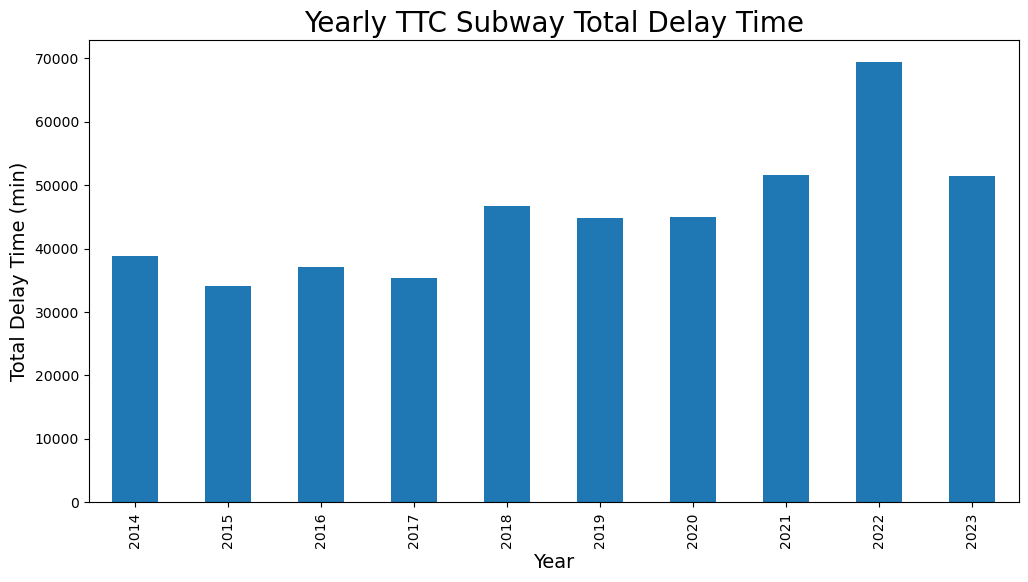

In [30]:
# Total delay counts by year
yearly_delay_time = real_delay.groupby(real_delay.index.year)["Min Delay"].sum()
yearly_delay_time.plot(kind = "bar", figsize = (12, 6))
plt.title("Yearly TTC Subway Total Delay Time", fontsize = 20)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Total Delay Time (min)", fontsize = 14)

plt.show()

More delay events during 2022.

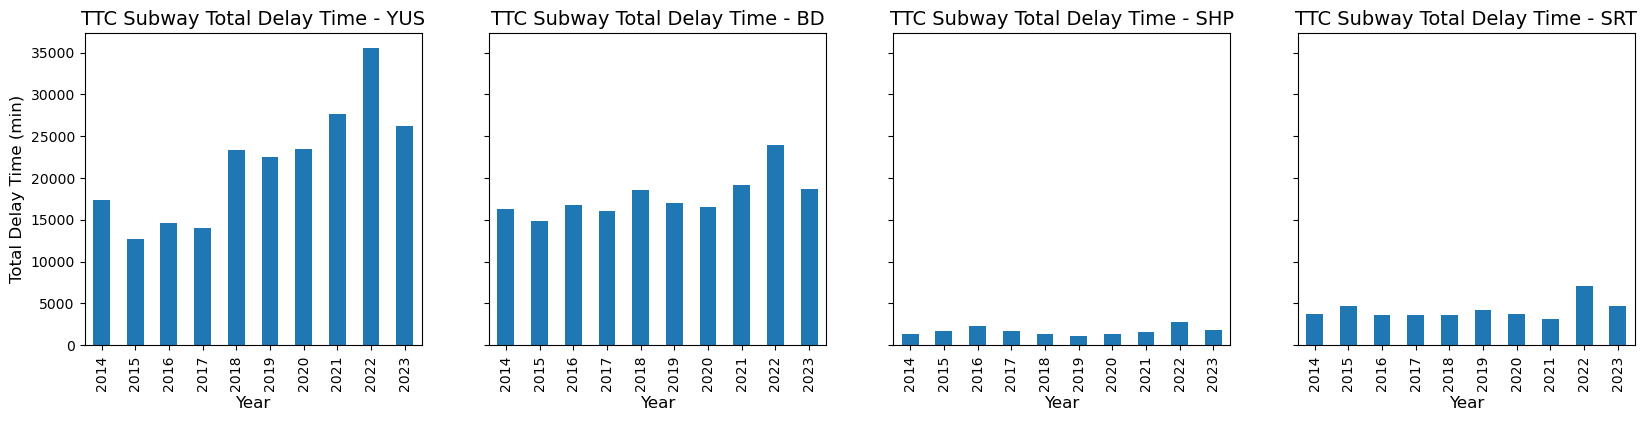

In [31]:
# Total delay counts by year
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    yearly_delay_time_line = line.groupby(line.index.year)["Min Delay"].sum()
    yearly_delay_time_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


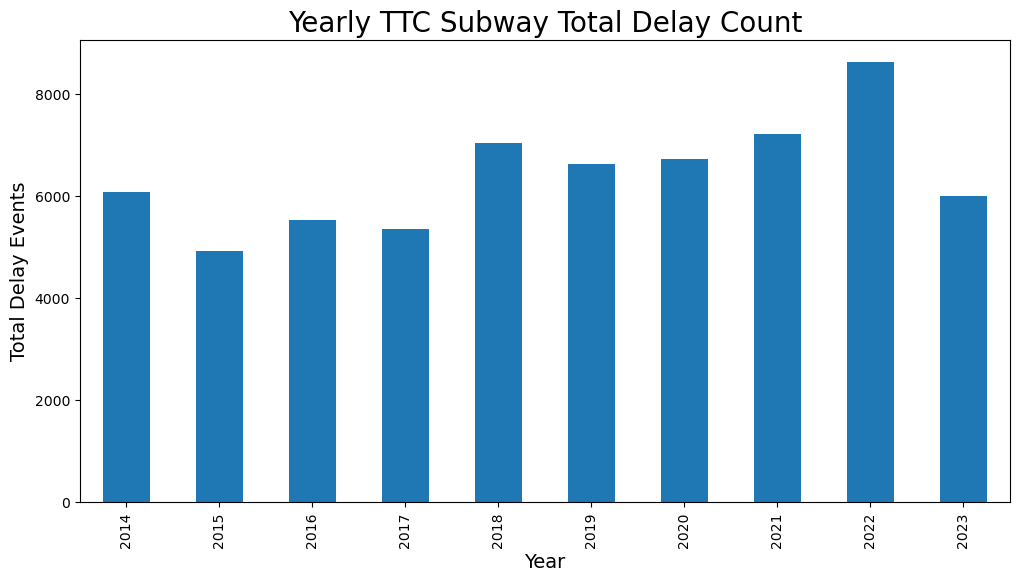

In [32]:
# Total number of delay by year
yearly_delay_count = real_delay.groupby(real_delay.index.year)["Min Delay"].count()
yearly_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Yearly TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)

plt.show()

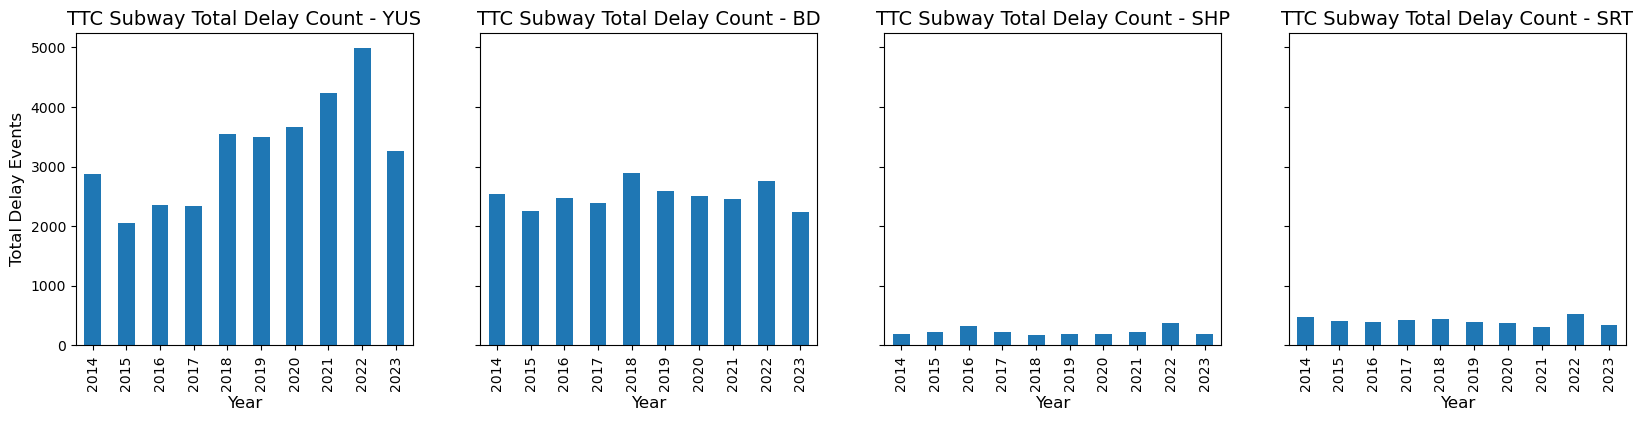

In [33]:
# Total number of delay by year
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    yearly_delay_count_line = line.groupby(line.index.year)["Min Delay"].count()
    yearly_delay_count_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Count - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


Overall, the number of delays events are the same for Bloor-Danford line, Sheppard line and Scarbough Rail Transit. However, Line 1 had significant increasing in delay time and the number of the delay events since 2018. The potential cause is the ATC project.

In [34]:
no_ATC = real_delay[~real_delay["Code"].str.contains("ATC")]
no_ATC["Code"].unique()

array(['MUO', 'MUSAN', 'SUDP', 'MUI', 'TUNOA', 'ERTC', 'EUDO', 'EUBK',
       'ERPR', 'PUSO', 'SUUT', 'TUO', 'MUPR1', 'MUPAA', 'PUSNT', 'MRWEA',
       'MUNOA', 'PUSTS', 'EUTRD', 'PUSSW', 'TUSUP', 'PRSA', 'MUCL',
       'TUNIP', 'PRSO', 'MUIR', 'SUO', 'MRTO', 'MUPLB', 'EUNT', 'TUOS',
       'MRO', 'TRNOA', 'SUSP', 'PUTWZ', 'EUTL', 'PUTIS', 'MUPLA', 'MUDD',
       'MUWR', 'MUD', 'PUSIS', 'ERDB', 'EUBO', 'MUSC', 'PUSRA', 'MUTO',
       'PUTR', 'TUS', 'EUCD', 'PUSCR', 'SUAP', 'ERDO', 'TUMVS', 'MUFM',
       'EUPI', 'PUSI', 'EUO', 'ERLV', 'SRDP', 'TUSC', 'TRTC', 'PUTDN',
       'EUOE', 'EUVE', 'TUCC', 'MUTD', 'EUTR', 'EUME', 'PUTIJ', 'EUYRD',
       'MUIS', 'PRW', 'EUSC', 'SUCOL', 'ERTL', 'PUSTP', 'EUAL', 'PUOPO',
       'MRNOA', 'PUSCA', 'MRDD', 'SUAE', 'PUTSC', 'SUEAS', 'EUCA', 'EUAC',
       'MUFS', 'TUKEY', 'SUBT', 'ERNT', 'SUPOL', 'MUIRS', 'MUWEA',
       'EUNEA', 'ERAC', 'TUDOE', 'MRPLB', 'PUSTC', 'SRO', 'TRNIP', 'PUTO',
       'SUROB', 'EUVA', 'ERO', 'PUCSC', 'MUIE', 'SRAP', 'PUTOE'

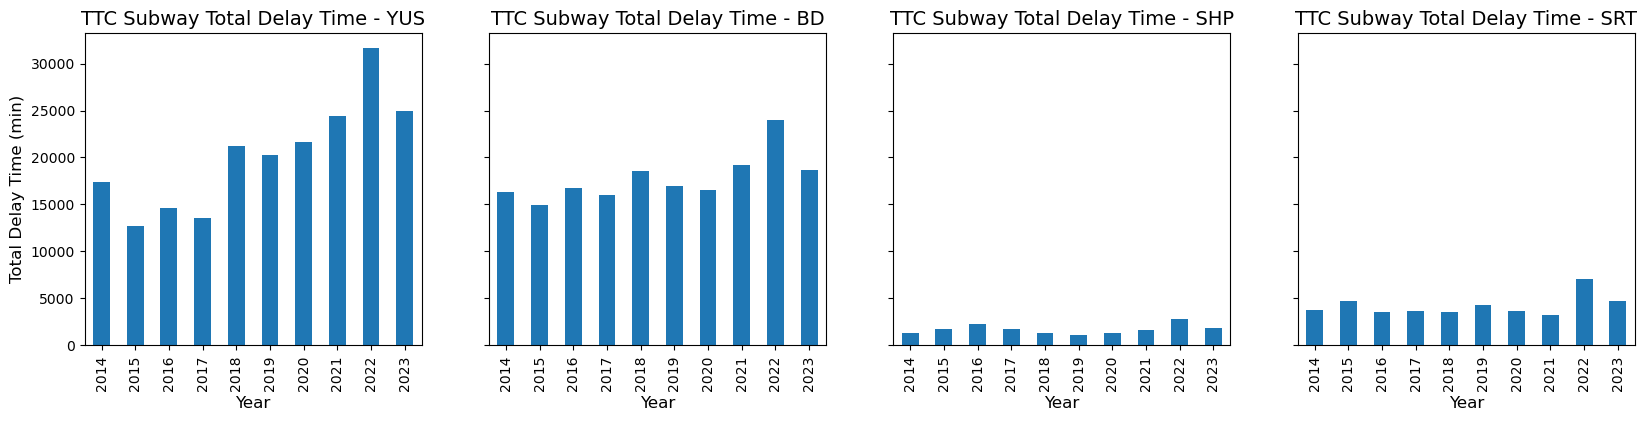

In [35]:
# Total delay counts by year
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = no_ATC[no_ATC["Line"] == subway_lines[i]]    
    yearly_delay_time_line_no_ATC = line.groupby(line.index.year)["Min Delay"].sum()
    yearly_delay_time_line_no_ATC.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


How about delay time caused by no operator immediately available?

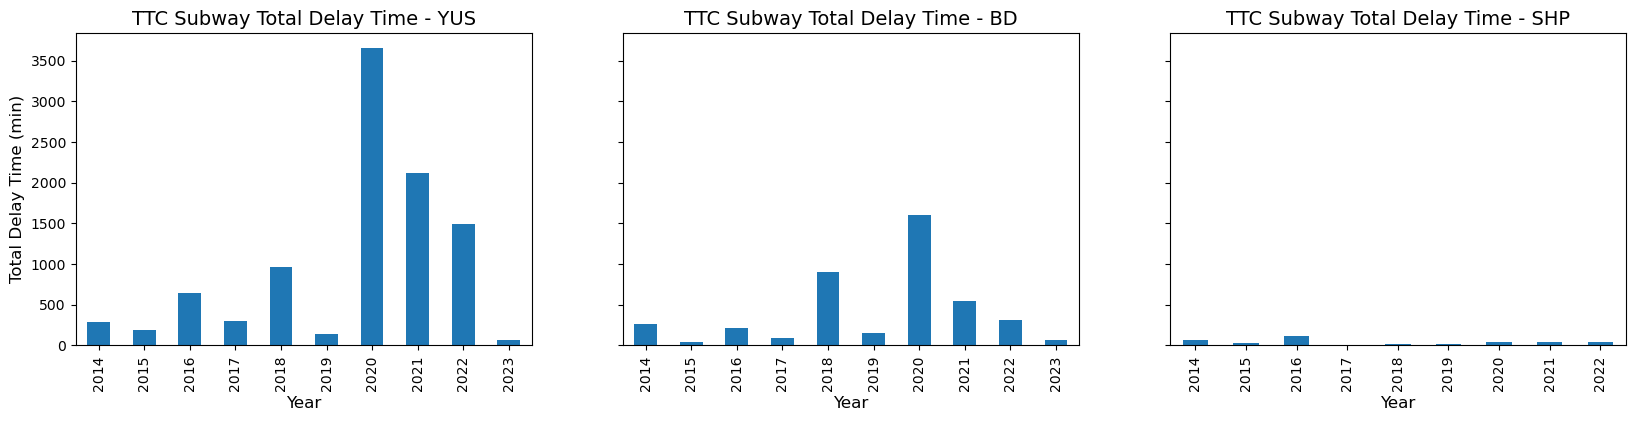

In [36]:
# Total delay minutes due to no operator immediate available
fig, axs = plt.subplots(1, 3, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(3):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "MUESA") | (real_delay["Code"] == "MUNOA") | (real_delay["Code"] == "TUNOA"))]    
    yearly_delay_time_line_no_operator = line.groupby(line.index.year)["Min Delay"].sum()
    yearly_delay_time_line_no_operator.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


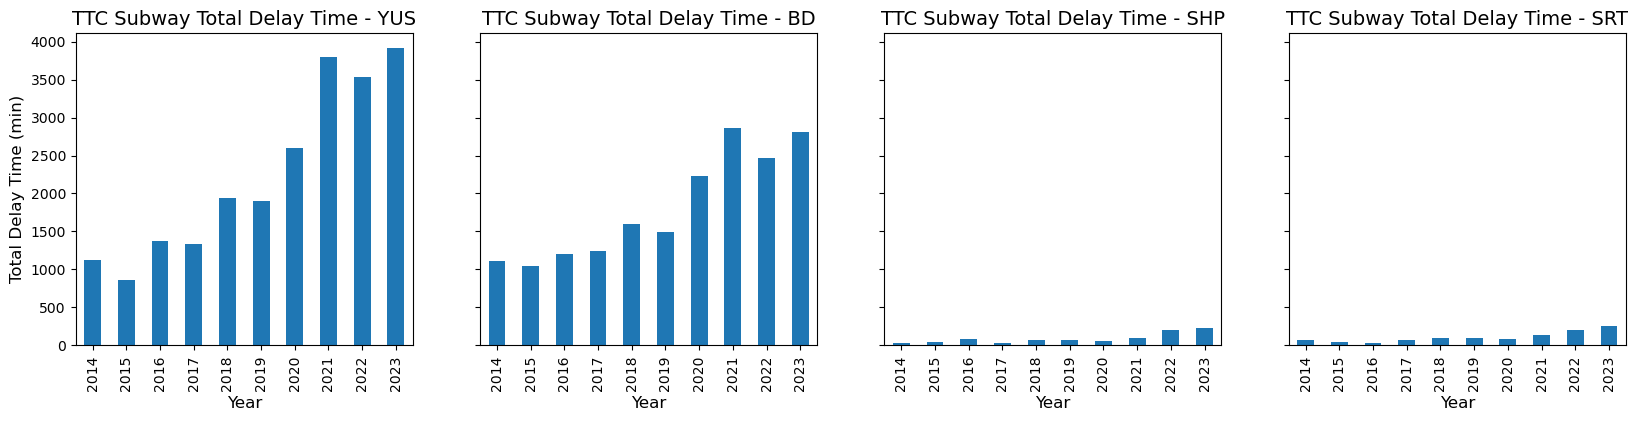

In [37]:
# Total delay minutes due to disorderly patrons
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "SUDP") | (real_delay["Code"] == "SRDP"))]    
    yearly_delay_time_line_patrons = line.groupby(line.index.year)["Min Delay"].sum()
    yearly_delay_time_line_patrons.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


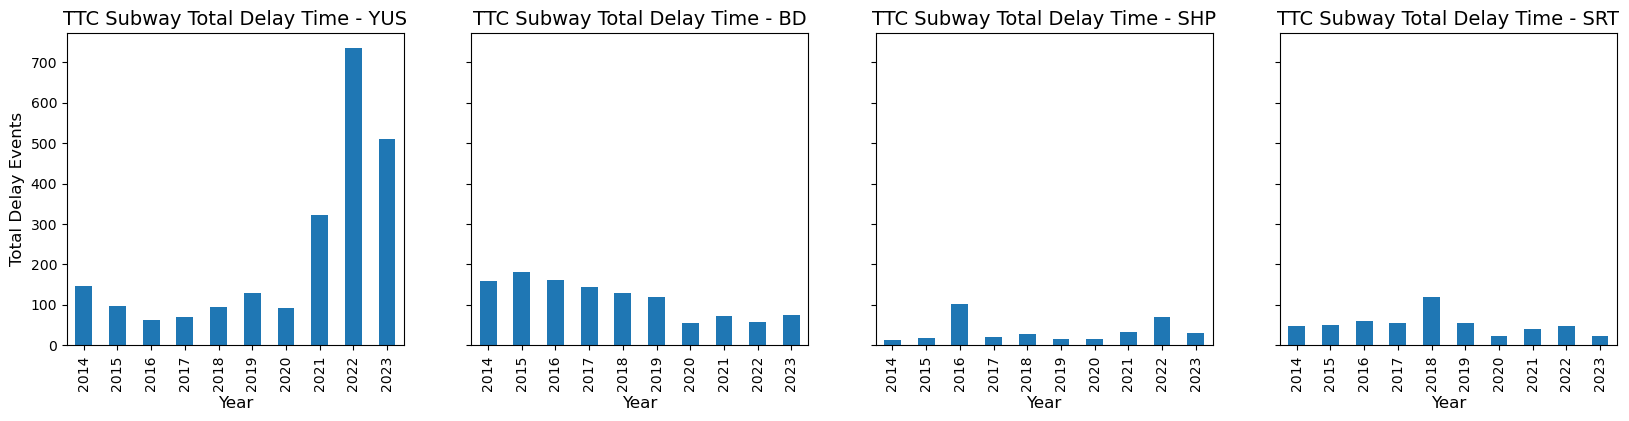

In [38]:
# Total delay minutes due to OPTO (COMMS) Train Door Monitoring or door problem - faulty equipment
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & real_delay["Code"].isin(["PUOPO", "EUDO", "ERDO"])]    
    yearly_delay_time_line_faulty_door = line.groupby(line.index.year)["Min Delay"].count()
    yearly_delay_time_line_faulty_door.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


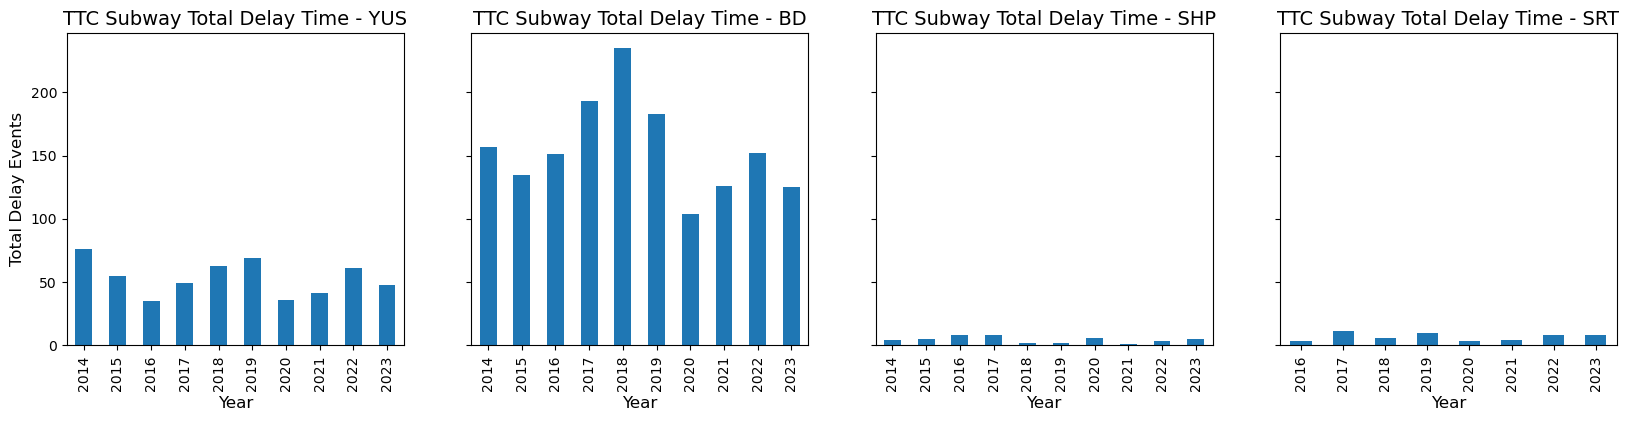

In [39]:
# Total delay minutes due to Door Problems - Passenger Related or Door Problems - Debris Related
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & real_delay["Code"].isin(["MUD", "MUDD", "MRD", "MRDD"])]    
    yearly_delay_time_line_obstacle_door = line.groupby(line.index.year)["Min Delay"].count()
    yearly_delay_time_line_obstacle_door.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


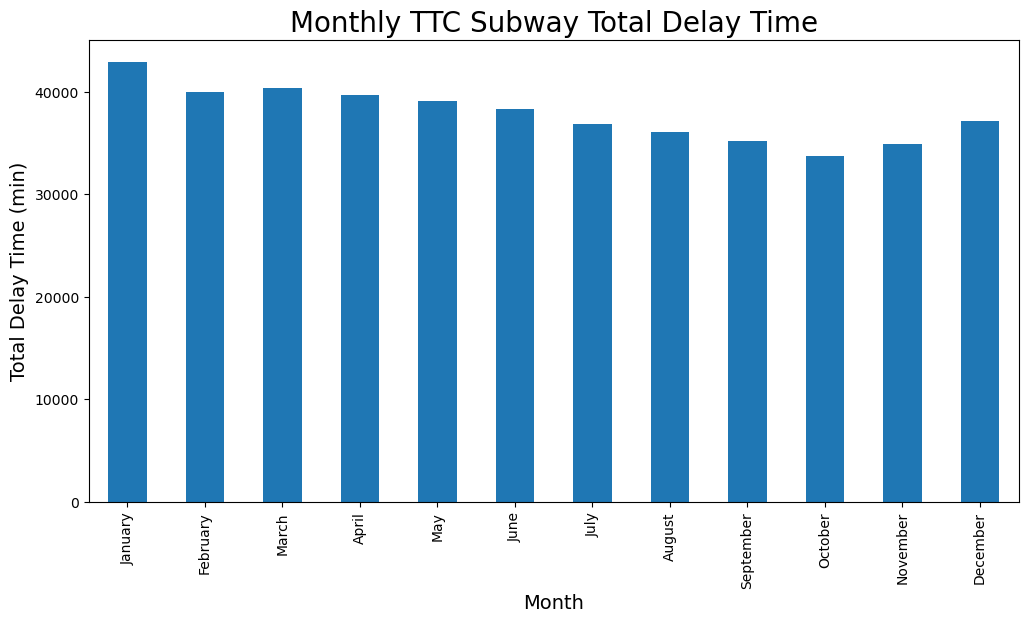

In [40]:
# Total delay time by months
monthly_delay_time = real_delay.groupby(real_delay.index.month)["Min Delay"].sum()
monthly_delay_time.plot(kind = "bar", figsize = (12, 6))
plt.title("Monthly TTC Subway Total Delay Time", fontsize = 20)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Total Delay Time (min)", fontsize = 14)
plt.xticks(ticks = np.arange(12), labels = ["January","February","March","April","May","June","July", "August", "September", "October", "November", "December"])

plt.show()

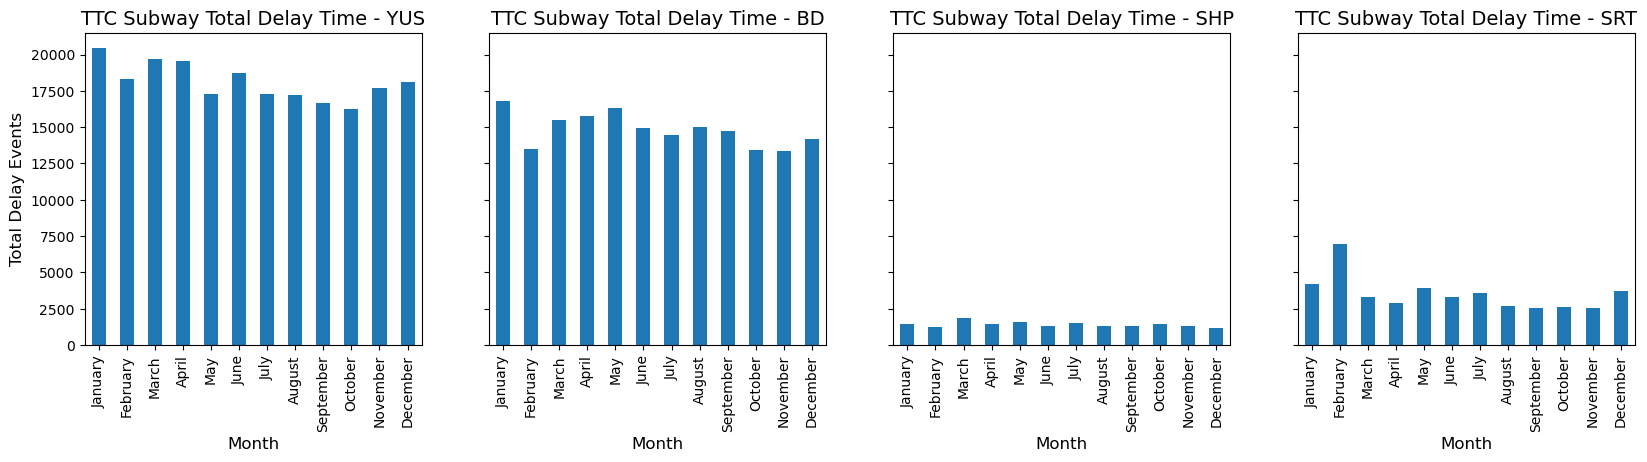

In [41]:
# Total number of delay by month
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    monthly_delay_time_line = line.groupby(line.index.month)["Min Delay"].sum()
    monthly_delay_time_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Month", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)
    axs[i].set_xticks(ticks = np.arange(12), labels = ["January","February","March","April","May","June","July", "August", "September", "October", "November", "December"])

plt.subplots_adjust(top=0.5)
plt.show()


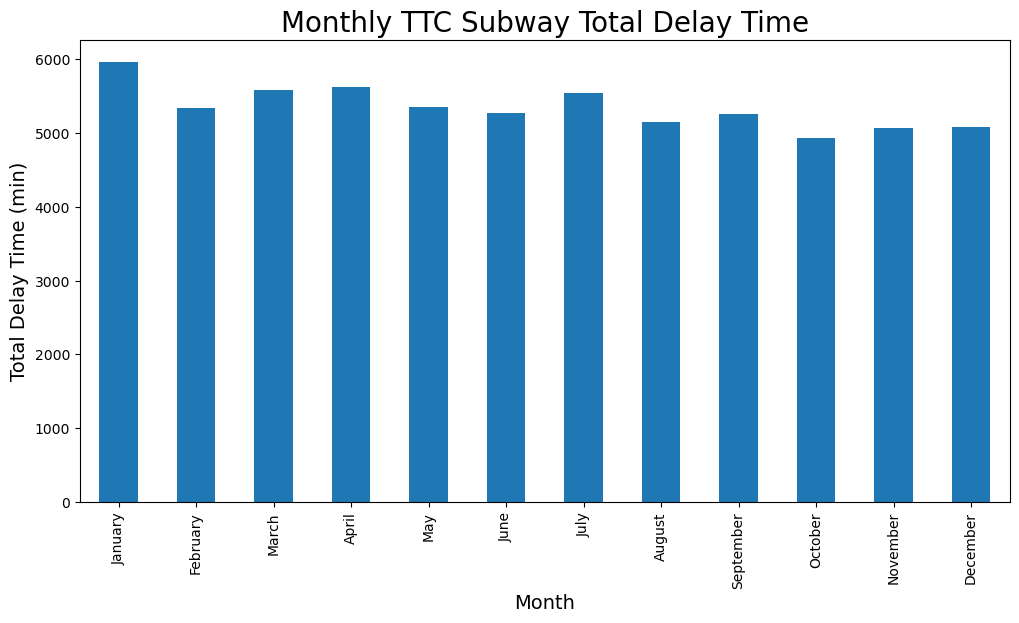

In [42]:
## Total number of delay by months
monthly_delay_count = real_delay.groupby(real_delay.index.month)["Min Delay"].count()
monthly_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Monthly TTC Subway Total Delay Time", fontsize = 20)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Total Delay Time (min)", fontsize = 14)
plt.xticks(ticks = np.arange(12), labels = ["January","February","March","April","May","June","July", "August", "September", "October", "November", "December"])

plt.show()

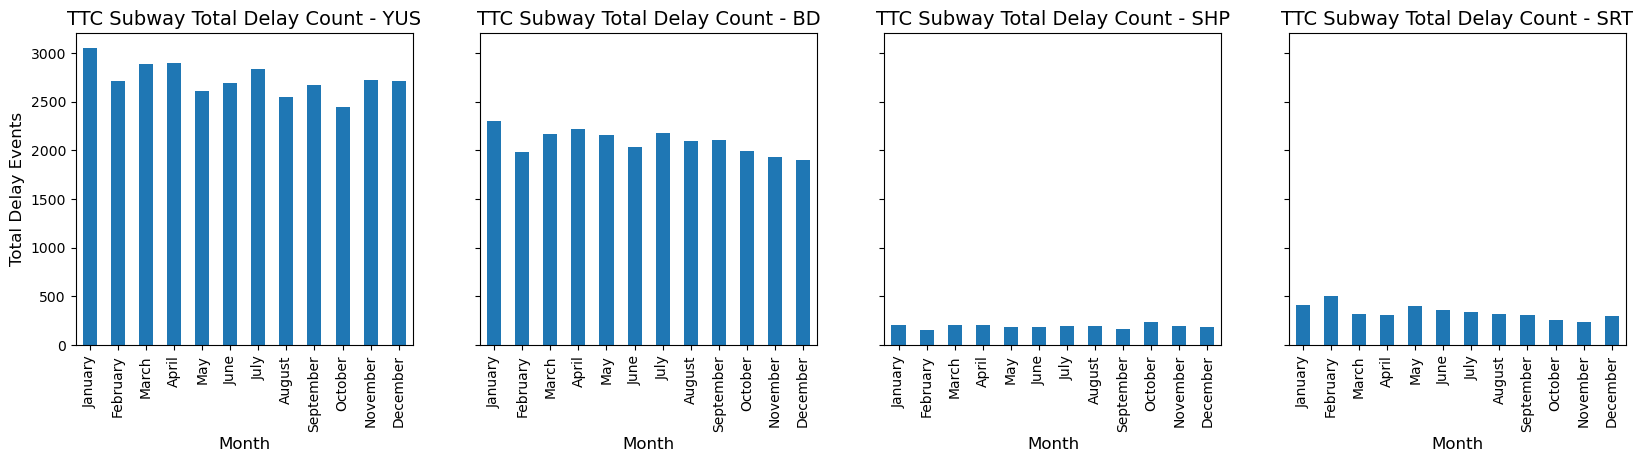

In [43]:
# Total number of delay by month
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    monthly_delay_count_line = line.groupby(line.index.month)["Min Delay"].count()
    monthly_delay_count_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Count - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Month", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)
    axs[i].set_xticks(ticks = np.arange(12), labels = ["January","February","March","April","May","June","July", "August", "September", "October", "November", "December"])

plt.subplots_adjust(top=0.5)
plt.show()


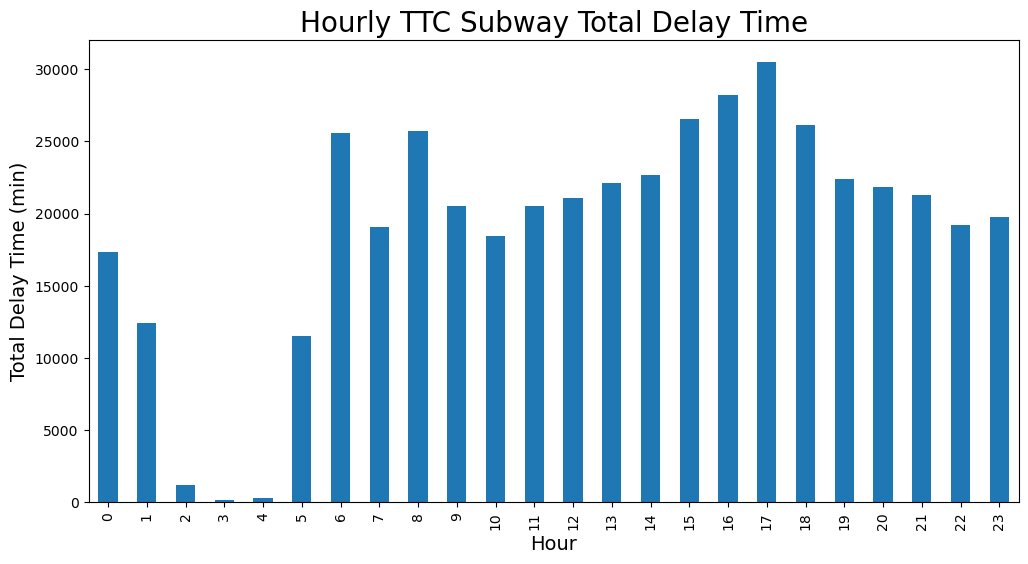

In [44]:
# Total delay time by hours
hourly_delay_time = real_delay.groupby(real_delay.index.hour)["Min Delay"].sum()
hourly_delay_time.plot(kind = "bar", figsize = (12, 6))
plt.title("Hourly TTC Subway Total Delay Time", fontsize = 20)
plt.xlabel("Hour", fontsize = 14)
plt.ylabel("Total Delay Time (min)", fontsize = 14)


plt.show()

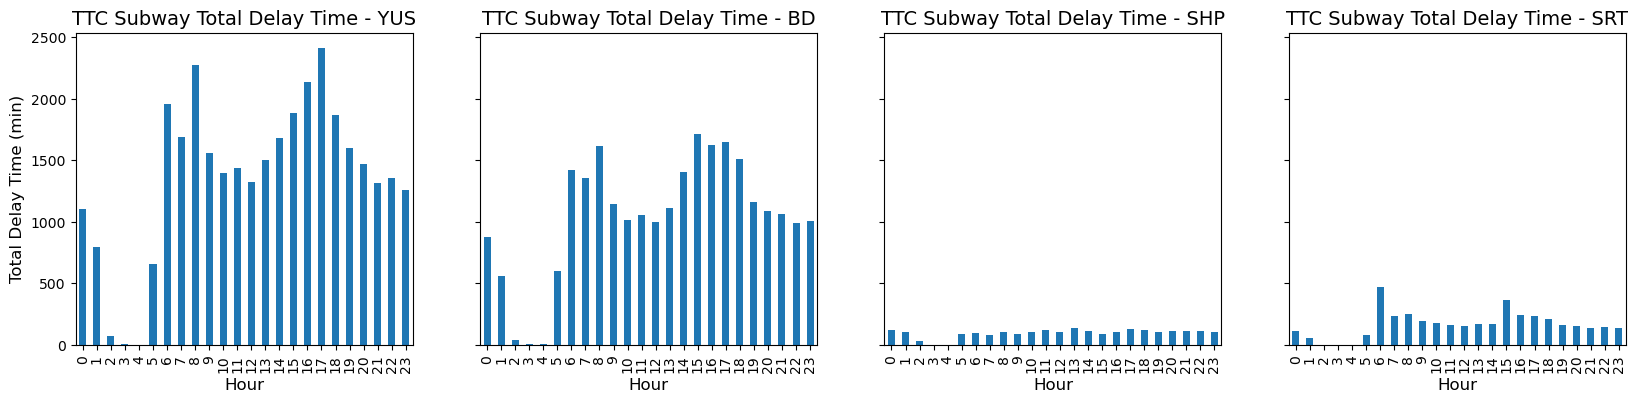

In [45]:
# Total number of delay by hour
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    hourly_delay_time_line = line.groupby(line.index.hour)["Min Delay"].count()
    hourly_delay_time_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Hour", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


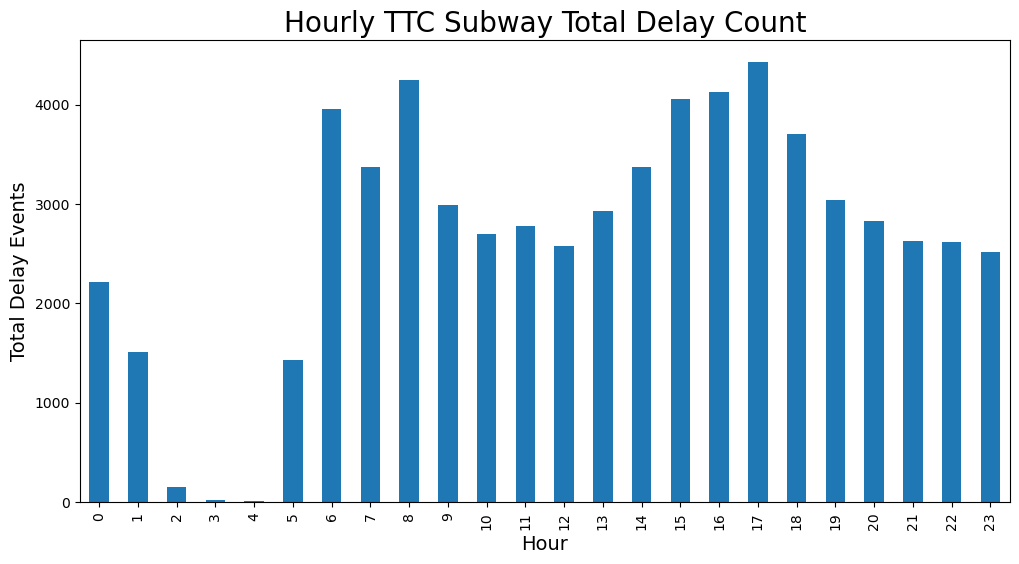

In [46]:
## Total number of delay by hours
hourly_delay_count = real_delay.groupby(real_delay.index.hour)["Min Delay"].count()
hourly_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Hourly TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Hour", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)

plt.show()

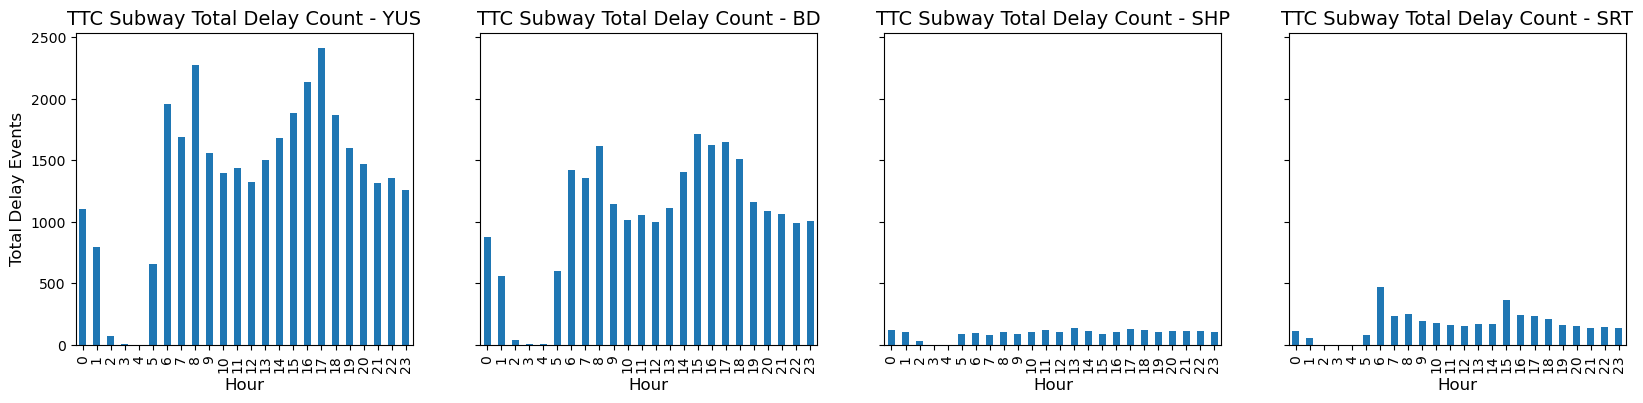

In [47]:
# Total number of delay by month
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    hourly_delay_count_line = line.groupby(line.index.hour)["Min Delay"].count()
    hourly_delay_count_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Count - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Hour", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


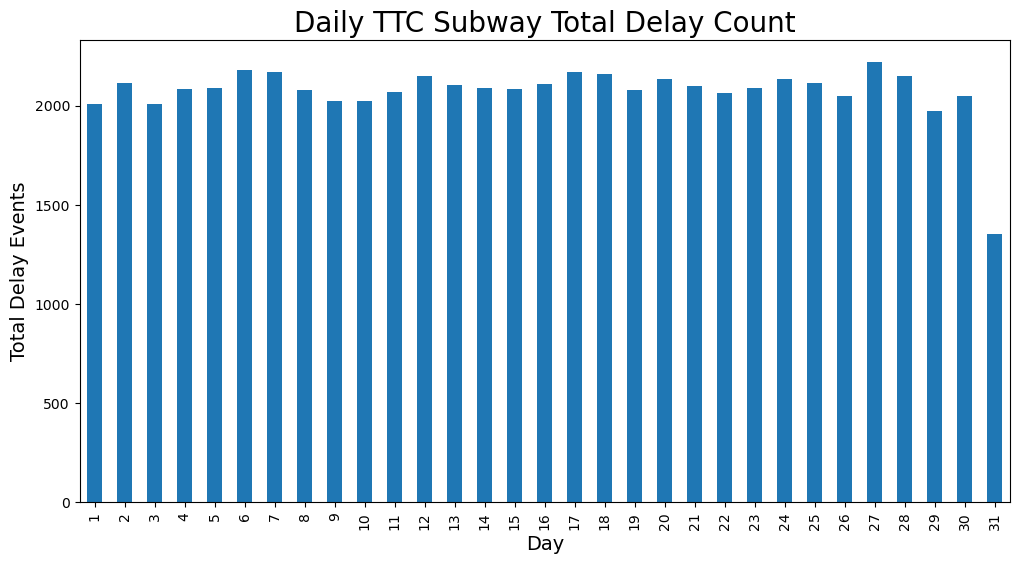

In [48]:
## Total number of delay by hours
daily_delay_count = real_delay.groupby(real_delay.index.day)["Min Delay"].count()
daily_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Daily TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Day", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)

plt.show()

Every day seems have the same amount of delays.

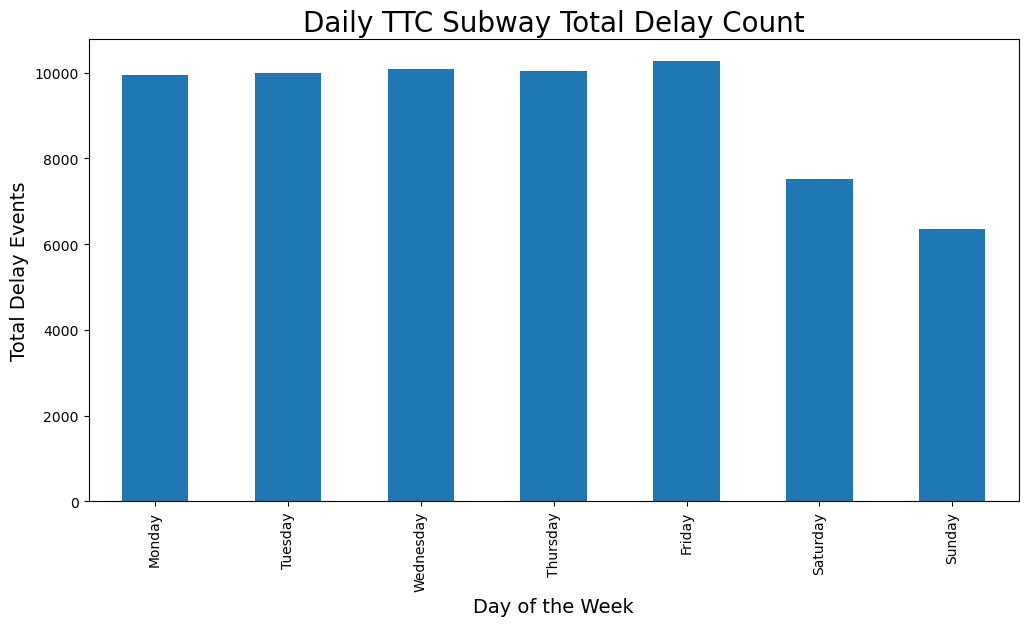

In [49]:
## Total number of delay by hours
weekdays_delay_count = real_delay.groupby(real_delay.index.dayofweek)["Min Delay"].count()
weekdays_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Daily TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Day of the Week", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)
plt.xticks(ticks = np.arange(7), labels = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

plt.show()

5. Top five reasons for short time and long time delays

In [50]:
# Top delay reasons less than 10 minutes in terms of total delay frequency
short_delay_reason = real_delay[real_delay["Min Delay"] <= 10]["Code description"].value_counts()
short_delay_reason.head(5)

Code description
Disorderly Patron                                           5992
Injured or ill Customer (On Train) - Medical Aid Refused    3394
Passenger Assistance Alarm Activated - No Trouble Found     3271
Door Problems - Faulty Equipment                            2547
ATC Project                                                 2092
Name: count, dtype: int64

In [51]:
# Top delay reasons less than 10 minutes in terms of total delay time
short_delay_reason_time = real_delay[real_delay["Min Delay"] <= 10].groupby("Code description")["Min Delay"].sum().sort_values(ascending = False)
short_delay_reason_time.head(5)

Code description
Disorderly Patron                                           28764
Injured or ill Customer (On Train) - Medical Aid Refused    16008
Door Problems - Faulty Equipment                            12573
Passenger Assistance Alarm Activated - No Trouble Found     12069
Injured or ill Customer (On Train) - Transported            11203
Name: Min Delay, dtype: int64

In [52]:
# Top delay reasons for less than 10 minutes
top_short_delay_reasons = list(set(list(short_delay_reason[0:5].index) + list(short_delay_reason_time[0:5].index)))
top_short_delay_reasons

['Door Problems - Faulty Equipment',
 'Injured or ill Customer (On Train) - Transported',
 'Passenger Assistance Alarm Activated - No Trouble Found',
 'Injured or ill Customer (On Train) - Medical Aid Refused',
 'Disorderly Patron',
 'ATC Project']

In [53]:
# Filter out short delays
top_short_delay_time = real_delay[real_delay["Code description"].isin(top_short_delay_reasons)]
top_short_delay_time

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00
2018-01-01 08:41:00,Monday,VICTORIA PARK STATION,EUDO,6,10,W,BD,5030,Door Problems - Faulty Equipment,08:00 - 09:00
2018-01-01 15:36:00,Monday,SHERBOURNE STATION,SUDP,5,10,E,BD,5269,Disorderly Patron,15:00 - 16:00
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 14:57:00,Sunday,EGLINTON STATION,SUDP,3,7,N,YUS,5931,Disorderly Patron,14:00 - 15:00
2017-12-31 20:46:00,Sunday,DAVISVILLE STATION,SUDP,9,14,N,YUS,5446,Disorderly Patron,20:00 - 21:00
2017-12-31 21:52:00,Sunday,YORK MILLS STATION,SUDP,3,8,N,YUS,5851,Disorderly Patron,21:00 - 22:00


['Door Problems\n - Faulty Equipment', 'Injured or ill Customer (On Train)\n - Transported', 'Passenger Assistance Alarm Activated\n - No Trouble Found', 'Injured or ill Customer (On Train)\n - Medical Aid Refused', 'Disorderly Patron', 'ATC Project']


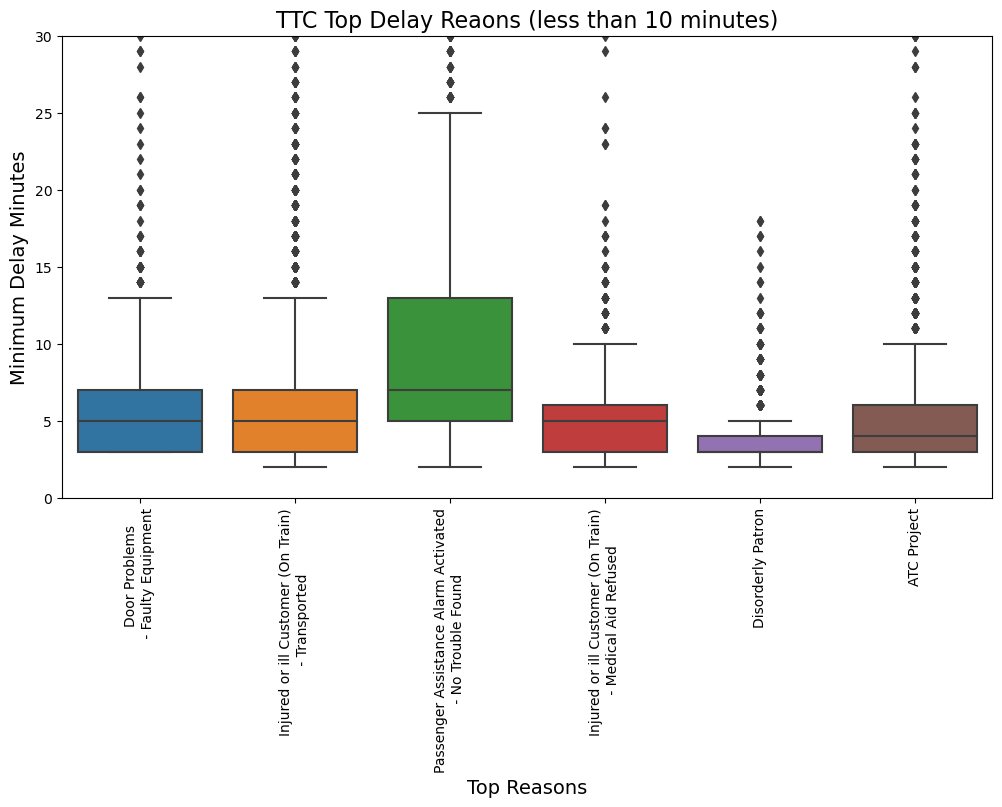

In [54]:
plt.figure(figsize = (12, 6))
formatted_legend = ['\n - '.join(s.split(' - ')) if ' - ' in s else s for s in top_short_delay_reasons]
print(formatted_legend)
sns.boxplot(x=top_short_delay_time["Code description"], y=top_short_delay_time["Min Delay"])
plt.title("TTC Top Delay Reaons (less than 10 minutes)", fontsize = 16)
plt.xlabel("Top Reasons", fontsize = 14)
plt.ylabel("Minimum Delay Minutes", fontsize = 14)
plt.xticks(range(len(formatted_legend)), formatted_legend, rotation = 90)
plt.ylim(0,30)
plt.show()

In [55]:
# Top delay reasons more than 10 minutes
long_delay_reason = real_delay[real_delay["Min Delay"] > 10]["Code description"].value_counts()
long_delay_reason.head(5)

Code description
Injured or ill Customer (On Train) - Transported    982
Unauthorized at Track Level                         882
Disorderly Patron                                   829
Fire/Smoke Plan B - Source TTC                      636
Passenger Other                                     501
Name: count, dtype: int64

In [56]:
long_delay_reason_time = real_delay[real_delay["Min Delay"] > 10].groupby("Code description")["Min Delay"].sum().sort_values(ascending = False)
long_delay_reason_time.head(5)

Code description
Priority One - Train in Contact With Person         24742
Unauthorized at Track Level                         18962
Fire/Smoke Plan B - Source TTC                      17430
Injured or ill Customer (On Train) - Transported    16760
Disorderly Patron                                   13665
Name: Min Delay, dtype: int64

In [57]:
top_long_delay_reasons = list(set(list(long_delay_reason[0:5].index) + list(long_delay_reason_time[0:5].index)))
top_long_delay_reasons

['Injured or ill Customer (On Train) - Transported',
 'Priority One - Train in Contact With Person',
 'Passenger Other',
 'Unauthorized at Track Level',
 'Disorderly Patron',
 'Fire/Smoke Plan B - Source TTC']

In [58]:
top_long_delay_time = real_delay[real_delay["Code description"].isin(top_long_delay_reasons)]
top_long_delay_time

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00
2018-01-01 11:46:00,Monday,KENNEDY BD STATION,SUUT,4,8,W,BD,5046,Unauthorized at Track Level,11:00 - 12:00
2018-01-01 15:36:00,Monday,SHERBOURNE STATION,SUDP,5,10,E,BD,5269,Disorderly Patron,15:00 - 16:00
2018-01-01 16:47:00,Monday,VICTORIA PARK STATION,MUPR1,62,67,W,BD,5225,Priority One - Train in Contact With Person,16:00 - 17:00
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 20:46:00,Sunday,DAVISVILLE STATION,SUDP,9,14,N,YUS,5446,Disorderly Patron,20:00 - 21:00
2017-12-31 21:33:00,Sunday,QUEEN STATION,SUUT,5,9,N,YUS,5736,Unauthorized at Track Level,21:00 - 22:00
2017-12-31 21:52:00,Sunday,YORK MILLS STATION,SUDP,3,8,N,YUS,5851,Disorderly Patron,21:00 - 22:00


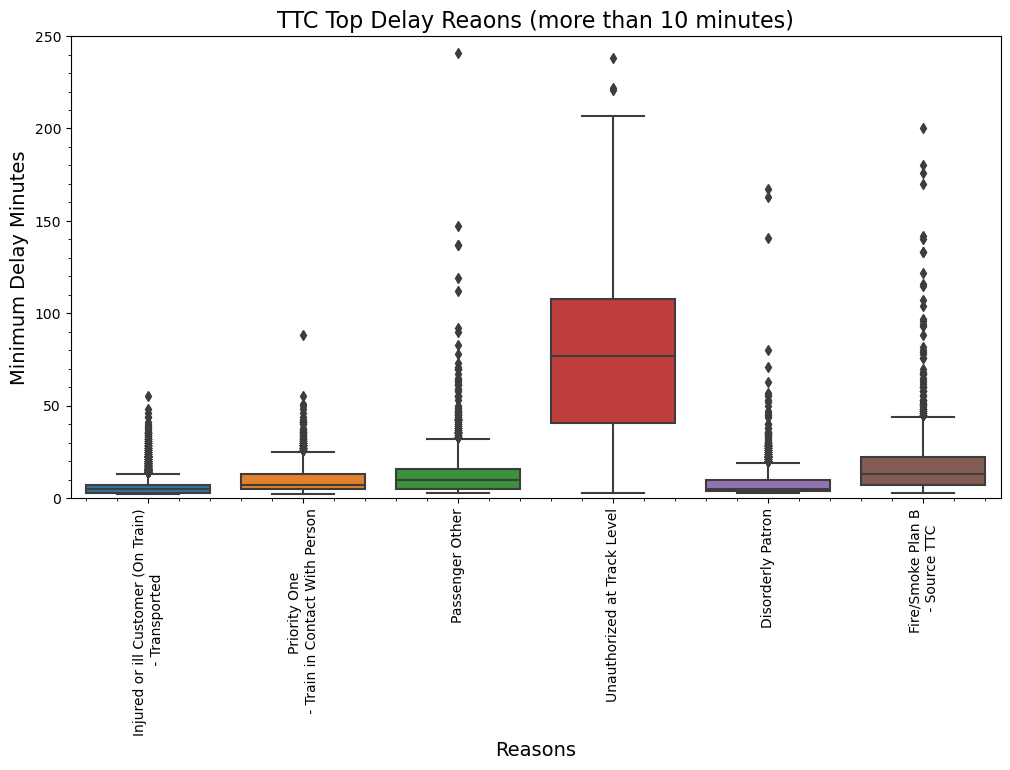

In [59]:
plt.figure(figsize = (12, 6))
formatted_legend = ['\n - '.join(s.split(' - ')) if ' - ' in s else s for s in top_long_delay_reasons]
sns.boxplot(x=top_long_delay_time["Code description"], y=top_long_delay_time["Min Delay"])
plt.title("TTC Top Delay Reaons (more than 10 minutes)", fontsize = 16)
plt.xlabel("Reasons", fontsize = 14)
plt.ylabel("Minimum Delay Minutes", fontsize = 14)
plt.xticks(range(len(formatted_legend)), formatted_legend, rotation = 90)
plt.ylim(0, 250)
plt.minorticks_on()
plt.show()

6. Mechanical Issues

Codes start with "E" or "P" are mechanical or signal issues from TTC.

In [60]:
TTC_delay_code_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Code              200 non-null    object
 1   Code description  200 non-null    object
dtypes: object(2)
memory usage: 4.2+ KB


In [61]:
mech_code = [TTC_delay_code_name["Code"][i] for i in range(len(TTC_delay_code_name["Code"])) if isinstance(TTC_delay_code_name["Code"][i], str) and (TTC_delay_code_name["Code"][i].startswith("E") or TTC_delay_code_name["Code"][i].startswith("P"))]
print(mech_code)

['EUAC', 'EUAL', 'EUATC', 'EUBK', 'EUBO', 'EUCA', 'EUCD', 'EUCH', 'EUCO', 'EUDO', 'EUECD', 'EUHV', 'EULT', 'EULV', 'EUME', 'EUNEA', 'EUNT', 'EUO', 'EUOE', 'EUOPO', 'EUPI', 'EUSC', 'EUTL', 'EUTM', 'EUTR', 'EUTRD', 'EUVA', 'EUVE', 'EUYRD', 'PUATC', 'PUCBI', 'PUCSC', 'PUCSS', 'PUDCS', 'PUMEL', 'PUMO', 'PUMST', 'PUOPO', 'PUSAC', 'PUSBE', 'PUSCA', 'PUSCR', 'PUSEA', 'PUSI', 'PUSIO', 'PUSIS', 'PUSLC', 'PUSNT', 'PUSO', 'PUSRA', 'PUSSW', 'PUSTC', 'PUSTP', 'PUSTS', 'PUSWZ', 'PUSZC', 'PUTCD', 'PUTD', 'PUTDN ', 'PUTIJ', 'PUTIS', 'PUTNT', 'PUTO', 'PUTOE', 'PUTR', 'PUTS', 'PUTSC', 'PUTSM', 'PUTTC', 'PUTTP', 'PUTWZ', 'ERAC', 'ERBO', 'ERCD', 'ERCO', 'ERDB', 'ERDO', 'ERHV', 'ERLT', 'ERLV', 'ERME', 'ERNEA', 'ERNT', 'ERO', 'ERPR', 'ERRA', 'ERTB', 'ERTC', 'ERTL', 'ERTR', 'ERVE', 'ERWA', 'ERWS', 'PREL', 'PRO', 'PRS', 'PRSA', 'PRSL', 'PRSO', 'PRSP', 'PRST', 'PRSW', 'PRTST', 'PRW']


In [62]:
# Most common mechanical issues
mech_issues = real_delay[real_delay["Code"].isin(mech_code)].groupby("Code")["Min Delay"].count().sort_values(ascending = False)
mech_issues.head(10)

Code
EUDO     2151
PUOPO    1612
EUNT      998
EUBK      876
PUSTS     571
ERDO      521
ERTC      503
EUBO      496
EUPI      388
PUSTC     352
Name: Min Delay, dtype: int64

As the table above, door issues (EUDO, PUOPO, ERDO) are the most common mechanical issues. Followed by break issues.

In [63]:
# Total number of mechanical issues over ten years
mech_issues.values.sum()

15561

In [64]:
print("There are {}% of delay caused by mechanical issues.".format(round(mech_issues.values.sum() / len(real_delay.index)*100, 2)))

There are 24.24% of delay caused by mechanical issues.


In [65]:
# Number of door issues
door_issues = real_delay[real_delay["Code"].isin(["PUOPO", "EUDO", "ERDO", "MUD", "MUDD", "MRD", "MRDD"])]
print("There are {}% of mechanical issues were related to doors.".format(round(door_issues["Vehicle"].count()/mech_issues.values.sum() * 100, 2)))

There are 41.61% of mechanical issues were related to doors.


In [66]:
# Number of brake issues
brake_issues = real_delay[real_delay["Code"]=="EUBK"]
print("There are {}% of mechanical issues were related to brakes.".format(round(brake_issues["Vehicle"].count()/mech_issues.values.sum() * 100, 2)))

There are 5.63% of mechanical issues were related to brakes.


In [67]:
print("There were {} trains experienced delay.".format(real_delay["Vehicle"].nunique()))

There were 908 trains experienced delay.


In [68]:
# Creat a new Dataframe
train = pd.DataFrame()
# Count how many delay from each train
train["Count"] = real_delay[(real_delay["Code"].isin(mech_code)) & (real_delay["Vehicle"] != 0)].groupby(["Vehicle"])["Code"].count().sort_values(ascending = False)
train.head()

,Count
Vehicle,
3007,133
3017,103
3025,94
3013,90
3000,88


In [69]:
# Find the subway lines for each vehicle
train["Line"] = [real_delay[real_delay["Vehicle"] == num]["Line"].unique() for num in train.index]
# Convert the list to string
train['Line'] = train['Line'].apply(lambda x: ', '.join(sorted(x)))
train.head()

,Count,Line
Vehicle,,
3007,133,"BD, SRT"
3017,103,SRT
3025,94,SRT
3013,90,SRT
3000,88,SRT


In [70]:
# Find the subway lines for each vehicle
train["Year"] = [real_delay[real_delay["Vehicle"] == num].index.year.unique().astype(str) for num in train.index]
# Convert the list to string
train['Year'] = train['Year'].apply(lambda x: ', '.join(sorted(x)))
train.head()

,Count,Line,Year
Vehicle,,,
3007,133,"BD, SRT","2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021..."
3017,103,SRT,"2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021..."
3025,94,SRT,"2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021..."
3013,90,SRT,"2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021..."
3000,88,SRT,"2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021..."


C:\Users\wsmco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

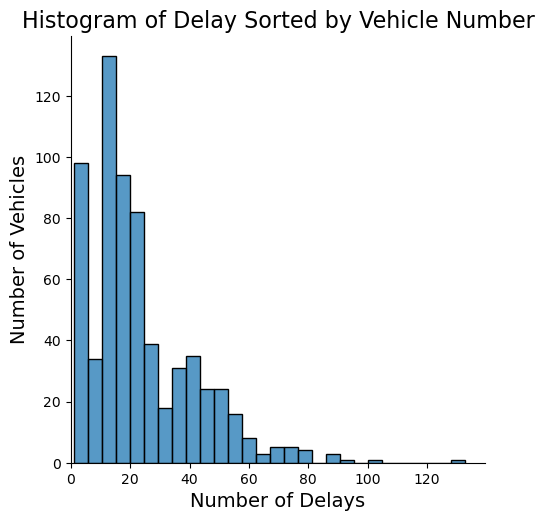

In [71]:
plt.figure(figsize = (12, 8))
# Plot the histogram of the delay event related to number of vehicles
sns.displot(train["Count"])
plt.title("Histogram of Delay Sorted by Vehicle Number", fontsize = 16)
plt.xlabel("Number of Delays", fontsize = 14)
plt.ylabel("Number of Vehicles", fontsize = 14)
plt.xlim(0)

plt.show()

C:\Users\wsmco\AppData\Local\Temp\ipykernel_28940\1597058450.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["Count"])


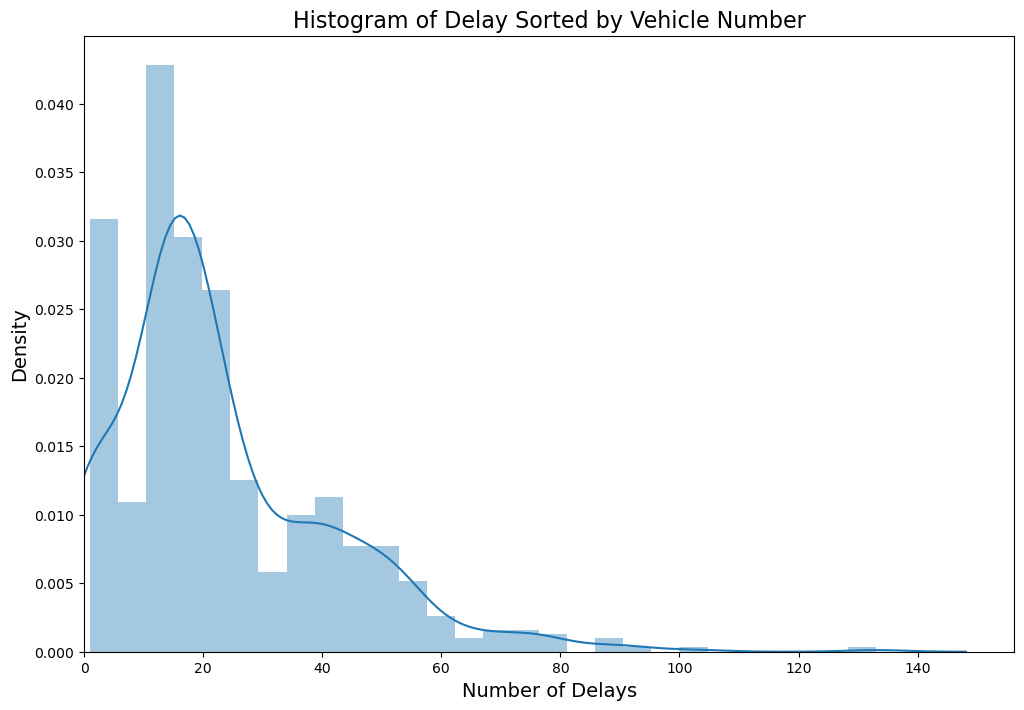

In [72]:
# Set the figure size
plt.figure(figsize = (12, 8))
# Plot the histogram of the delay event related to number of vehicles
sns.distplot(train["Count"])

# Add plot title, labels and set the limit
plt.title("Histogram of Delay Sorted by Vehicle Number", fontsize = 16)
plt.xlabel("Number of Delays", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.xlim(0)

plt.show()

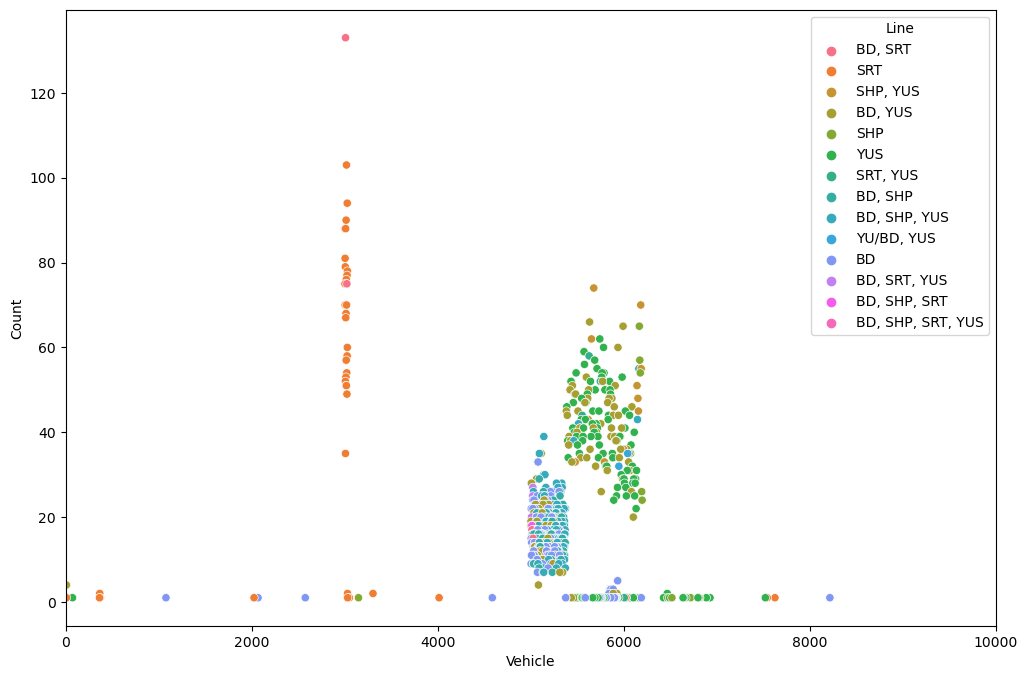

In [73]:
# See the vehicle number correlation
plt.figure(figsize = (12, 8))
sns.scatterplot(x = train.index, y = train["Count"], hue = train["Line"])
plt.xlim(0,10000)

plt.show()

7. Top Delay Reason for each station

In [74]:
real_delay["Station"].unique()

array(['SHEPPARD WEST STATION', 'MUSEUM STATION', 'KIPLING STATION',
       'COLLEGE STATION', 'WARDEN STATION', 'DONLANDS STATION',
       'KEELE STATION', 'KENNEDY SRT STATION', 'VICTORIA PARK STATION',
       'OLD MILL STATION', 'DAVISVILLE STATION', 'KENNEDY BD STATION',
       'ST GEORGE BD STATION', 'SHERBOURNE STATION', 'EGLINTON STATION',
       'PAPE STATION', 'BLOOR STATION', 'ST PATRICK STATION',
       'MCCOWAN STATION', 'YORK MILLS STATION', 'FINCH STATION',
       'GREENWOOD STATION', 'KING STATION', 'WILSON STATION',
       'VAUGHAN MC STATION', 'WILSON YARD', 'GREENWOOD YARD',
       'UNION STATION', 'FINCH WEST STATION', 'COXWELL STATION',
       'YORKDALE STATION', 'ST CLAIR STATION', 'JANE STATION',
       'LAWRENCE STATION', 'MIDLAND STATION', 'BAY STATION',
       'EGLINTON WEST STATION', 'DUPONT STATION', 'WELLESLEY STATION',
       "QUEEN'S PARK STATION", 'ISLINGTON STATION', 'SPADINA YUS STATION',
       'DUFFERIN STATION', 'ELLESMERE STATION', 'ST CLAIR WEST ST

There are a lot of different name for one station. For example, "BLOOR SATION" and "BLOOR TO UNION" is the same station, which is "BLOOR STATION" in Line 1

Lets see the name for Yonge-Bloor station. Since they might call it either Bloor Station or Yonge Station. 

In [75]:
# Filter out the delays more than 1 minute
real_delay = delayed_data.loc[(delayed_data["Min Delay"] != 0) & (delayed_data["Min Gap"] != 0)]
real_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00
2018-01-01 02:09:00,Monday,KIPLING STATION,MUSAN,3,7,E,BD,5261,Unsanitary Vehicle,02:00 - 03:00
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00


In [76]:


TTC_delay_stations_YB = real_delay.copy()

TTC_delay_stations_YB = TTC_delay_stations_YB[TTC_delay_stations_YB["Station"].str.contains('BLOOR') | \
                                                   TTC_delay_stations_YB["Station"].str.contains('YONGE')]


TTC_delay_stations_YB.head()


,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 17:07:00,Monday,BLOOR STATION,PUSNT,6,10,S,YUS,5751,Signal Problem - No Trouble,17:00 - 18:00
2018-01-03 01:09:00,Wednesday,BLOOR STATION,SUO,13,18,N,YUS,5716,Passenger Other,01:00 - 02:00
2018-01-03 10:29:00,Wednesday,BLOOR STATION,SUUT,5,9,S,YUS,5956,Unauthorized at Track Level,10:00 - 11:00
2018-01-05 09:07:00,Friday,BLOOR STATION,PUSIS,3,5,S,YUS,5726,Signals Track Weather Related,09:00 - 10:00
2018-01-05 10:12:00,Friday,YONGE BD STATION,EUDO,4,6,E,BD,5128,Door Problems - Faulty Equipment,10:00 - 11:00


Bloor-Yonge station is the interchange station between Line 1 and Line 2.

For line 2, the name of station is "Yonge station". For line 1, the name of the station is "Bloor Station"

In [77]:
## Based on the line code, replace the station name with either "Yonge station" or "Bloor Station"

real_delay.loc[(real_delay['Line'] == 'BD') & real_delay["Station"].isin(TTC_delay_stations_YB['Station']), 'Station'] = "YONGE BD STATION"
real_delay.loc[(real_delay['Line'] == 'YUS') & real_delay["Station"].isin(TTC_delay_stations_YB['Station']), 'Station'] = "BLOOR STATION"


real_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00
2018-01-01 02:09:00,Monday,KIPLING STATION,MUSAN,3,7,E,BD,5261,Unsanitary Vehicle,02:00 - 03:00
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00


Lets see the name for St Grorge station

In [79]:
TTC_delay_stations_SG = real_delay.copy()

TTC_delay_stations_SG = TTC_delay_stations_SG[TTC_delay_stations_SG["Station"].str.contains('GEORGE')]

TTC_delay_stations_SG.drop_duplicates(subset="Station",inplace=True)

TTC_delay_stations_SG[["Station","Line"]].reset_index(drop=True).head(30)

,Station,Line
0,ST GEORGE BD STATION,BD
1,ST GEORGE YUS STATION,YUS
2,UNION TO ST GEORGE,YUS
3,ST GEORGE TO BAY STATI,BD
4,ST GEORGE AND BROADVIE,BD
5,ST GEORGE YU STATION,YUS
6,ST. GEORGE STATION,YUS
7,ST GEORGE STAION - LE,BD
8,ST GEORGE TO QUEENS PA,YUS
9,ST GEORGE BD STATION -,BD


Based on the line code name the station naming, replace the station name with either "ST GEORGE BD STATION" or "ST GEORGE YUS STATION"

In [82]:

real_delay.loc[
    (real_delay['Line'] == 'BD') & 
    real_delay['Station'].isin(TTC_delay_stations_SG['Station']), 
    'Station'
] = "TTC_delay_stations_SG"


real_delay.loc[
    (real_delay['Line'] == 'YUS') & 
    real_delay['Station'].isin(TTC_delay_stations_SG['Station']), 
    'Station'
] = "TTC_delay_stations_SG"



real_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00
2018-01-01 02:09:00,Monday,KIPLING STATION,MUSAN,3,7,E,BD,5261,Unsanitary Vehicle,02:00 - 03:00
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00


Lets see the name for Yonge-Sheppard station

In [84]:
TTC_delay_stations_SY = real_delay.copy()

TTC_delay_stations_SY = TTC_delay_stations_SY[TTC_delay_stations_SY["Station"].str.contains("SHEPPARD")]

TTC_delay_stations_SY.drop_duplicates(subset="Station",inplace=True)

TTC_delay_stations_SY[["Station","Line"]].reset_index(drop=True).head(30)

,Station,Line
0,SHEPPARD WEST STATION,YUS
1,SHEPPARD STATION,YUS
2,SHEPPARD WEST MIGRATI,YUS
3,SHEPPARD WEST PORTAL,YUS
4,SHEPPARD WEST MIGRATIO,YUS
5,SHEPPARD LINE,SHP
6,SHEPPARD WEST TO WILSO,YUS
7,VMC TO SHEPPARD WEST,YUS
8,SHEPPARD YONGE STATION,SHP
9,YUS/BD/SHEPPARD SUBWAY,YUS


Based on the line code name the station naming, replace the station name with either "SHEPPARD - YONGE STATION - YUS" or "SHEPPARD - YONGE STATION - SHP"

In [88]:
real_delay.loc[
    (real_delay['Line'] == 'YUS') & 
    real_delay['Station'].isin(TTC_delay_stations_SY['Station']), 
    'Station'
] = "SHEPPARD - YONGE STATION - YUS"


real_delay.loc[
    (real_delay['Line'] == 'SHP') & 
    real_delay['Station'].isin(TTC_delay_stations_SY['Station']), 
    'Station'
] = "SHEPPARD - YONGE STATION - SHP"



real_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD - YONGE STATION - YUS,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00
2018-01-01 02:09:00,Monday,KIPLING STATION,MUSAN,3,7,E,BD,5261,Unsanitary Vehicle,02:00 - 03:00
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00


In [83]:
## The count here shows number 
TTC_delay_stations_count = real_delay.groupby(["Station"]).agg(total_count=('Code', 'count'), max_delay_code=('Code', 'max')).sort_values(by='total_count', ascending=False)
TTC_delay_stations_count.head()

,total_count,max_delay_code
Station,,
FINCH STATION,2781,TUSUP
KENNEDY BD STATION,2761,TUSUP
SHEPPARD - YONGE STATION - YUS,2616,TUSUP
VAUGHAN MC STATION,2401,TUSUP
EGLINTON STATION,2352,TUSUP


In [84]:
TTC_delay_stations_count["max_delay_code"].unique()

array(['TUSUP', 'TUSC', 'TRTC', 'TUSET', 'TUS', 'TUTD', 'TUOS', 'TUST',
       'TRSET', 'TUATC', 'PUTSM', 'SRO', 'TUNOA', 'TUO', 'SUUT', 'TUMVS',
       'TRO', 'PRSO', 'SUDP', 'TUNIP', 'PUSTS', 'TUCC', 'MRTO', 'MUTO',
       'PUSNT', 'PUTIJ', 'PUTWZ', 'PUCSS', 'MUATC', 'ERTC', 'MUIS',
       'PUCSC', 'PUSI', 'PUSRA', 'PUSSW', 'MUPLB', 'PRSL', 'PRS', 'MUSC',
       'MUNOA', 'MUPAA', 'PUSCA', 'ERDO', 'MUTD', 'PUSZC', 'PUSIS', 'SUO',
       'EUVE', 'PUEWZ', 'ERHV', 'EUNT', 'SUEAS', 'MUI', 'MUDD', 'PUSTC',
       'EUDO', 'PUTO', 'EUBK', 'PRO', 'PRSA', 'PUTR', 'MUO', 'EUTRD',
       'EUATC', 'PUSIO', 'EUPI', 'PUMO', 'PUSTP', 'SUAP', 'PUTS', 'EUTM',
       'EUSC', 'MRWEA', 'MUPR1', 'PUATC', 'MUSAN', 'PUOPO', 'PUSAC',
       'ERPR', 'SREAS', 'SUG', 'EUBO', 'PRW'], dtype=object)

In [85]:
TTC_delay_stations_count[~TTC_delay_stations_count["max_delay_code"].isin(["TUSUP", "TUSC"])].head(10)

,total_count,max_delay_code
Station,,
MCCOWAN STATION,1551,TRTC
WARDEN STATION,1296,TUSET
KENNEDY SRT STATION,957,TRTC
ST CLAIR STATION,895,TUS
ISLINGTON STATION,793,TUTD
WELLESLEY STATION,705,TUS
COLLEGE STATION,703,TUOS
OSSINGTON STATION,677,TUST
SPADINA BD STATION,647,TUS


We are suspect that the door problem usually happen at the exchange stations between two lines since people may run to catch the subway. The relevent codes are: ["MUD", "MUDD", "MRD", "MRDD"]

In [86]:
real_delay[real_delay["Code"].isin(["MUD", "MUDD", "MRD", "MRDD"])].groupby("Station")["Min Delay"].count().sort_values(ascending = False).head(10)

Station
YONGE BD STATION         169
ST GEORGE BD STATION     109
KENNEDY BD STATION        84
ISLINGTON STATION         65
SHERBOURNE STATION        65
WARDEN STATION            63
SPADINA BD STATION        61
VICTORIA PARK STATION     56
KIPLING STATION           56
DUFFERIN STATION          53
Name: Min Delay, dtype: int64

In [102]:
## Create a dataframe for the door-related isssue which contain the station name and the number of door issue happened

door_issue = real_delay[real_delay["Code"].isin(["MUD", "MUDD", "MRD", "MRDD"])].groupby("Station")["Min Delay"].count().sort_values(ascending = False).head(10)

door_issue_pd = door_issue.reset_index()
door_issue_pd.columns = ['Station', 'Number of door Issues']


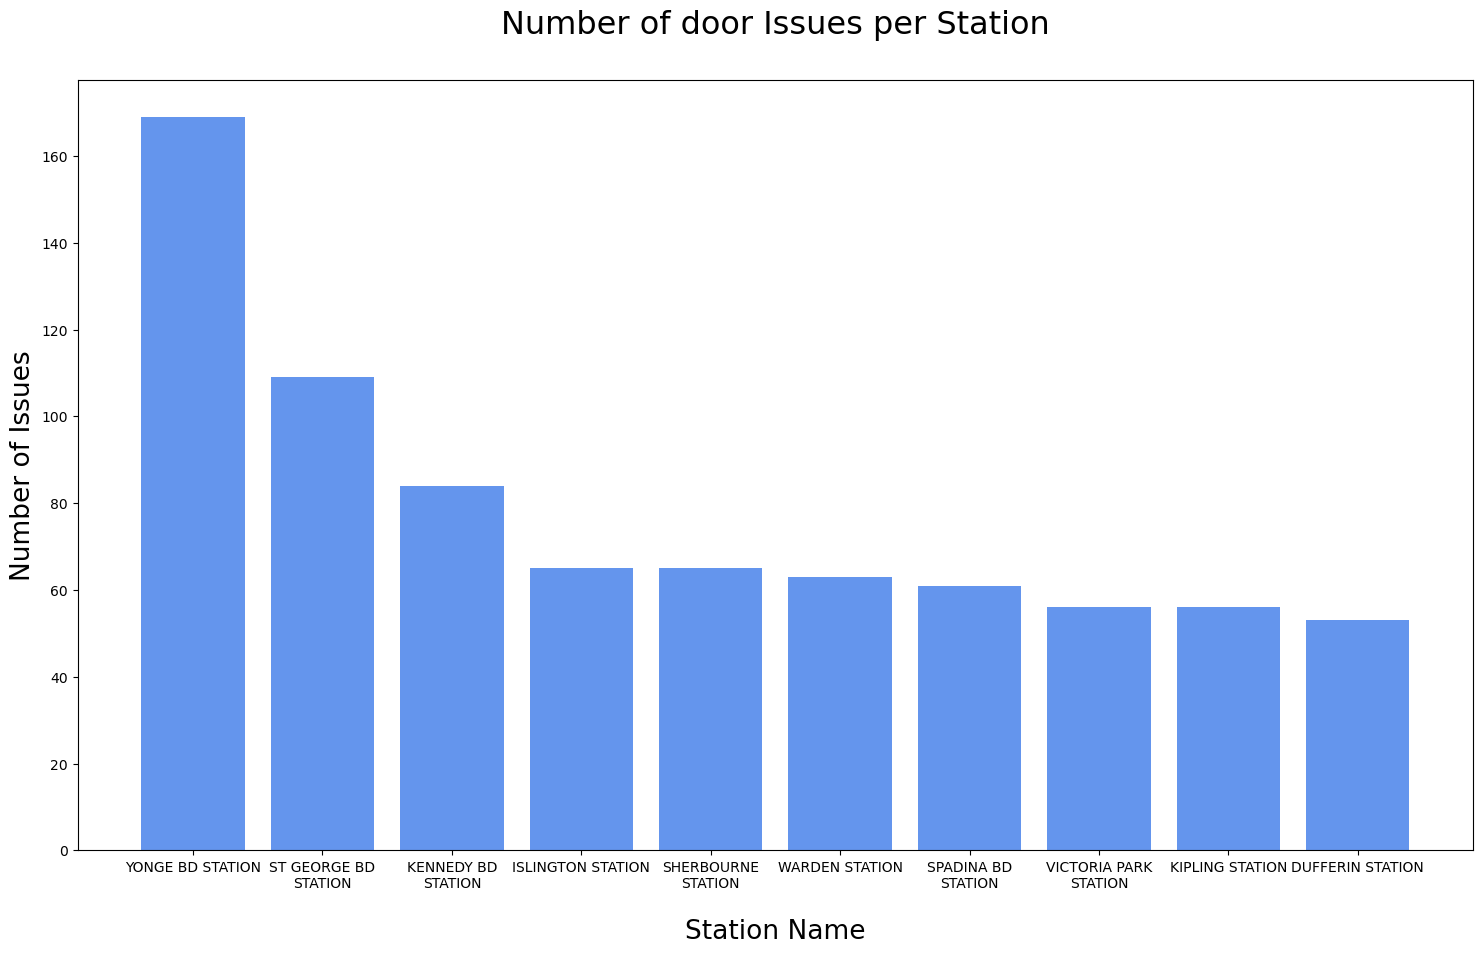

In [150]:
## Plot the graph

import textwrap
plt.figure(figsize = (18, 10))

door_issue_pd['Station'] = ['\n'.join(textwrap.wrap(label, 17)) for label in door_issue_pd['Station']]

plt.bar(door_issue_pd['Station'], door_issue_pd['Number of door Issues'], color='cornflowerblue')
plt.xlabel('Station Name',fontsize=19, labelpad=20)
plt.ylabel('Number of Issues',fontsize=19)
plt.title('Number of door Issues per Station',fontsize=23, y=1.05)


## Save as a image
plt.savefig('Number of door Issues per Station.png', dpi=600)

plt.show()




Yonge BD station and St. George BD station are two main interchange station with the most significant door issues due to passengers and debris. The potential reason is the subway schedule for two lines are too close. Passengers tried to exchange the subway at the last minute.

Delay reason for Yognge-Bloor station

In [89]:
TTC_delay_stations_YS = real_delay[real_delay["Station"] == "YONGE BD STATION"]


TTC_delay_stations_YS.head()
def to_list(series):
    return list(series)


TTC_delay_stations_YS.groupby("Code").agg(
    {'Code description': "unique", 'Min Delay': 'sum'}).sort_values(by='Min Delay', ascending=False).head(50)

,Code description,Min Delay
Code,,
MUPLB,[Fire/Smoke Plan B - Source TTC],1006
MUPR1,[Priority One - Train in Contact With Person],963
SUDP,[Disorderly Patron],940
SUUT,[Unauthorized at Track Level],793
MUDD,[Door Problems - Debris Related],624
MUIR,[Injured or ill Customer (On Train) - Medical ...,502
MUI,[Injured or ill Customer (On Train) - Transpor...,494
SUO,[Passenger Other],395
EUDO,[Door Problems - Faulty Equipment],277


In [90]:
TTC_delay_stations_BS = real_delay[real_delay["Station"] == "BLOOR STATION"]



def to_list(series):
    return list(series)


TTC_delay_stations_BS.groupby("Code").agg(
    {'Code description': "unique", 'Min Delay': 'count'}).sort_values(by='Min Delay', ascending=False).head(20)

,Code description,Min Delay
Code,,
SUDP,[Disorderly Patron],371
MUPAA,[Passenger Assistance Alarm Activated - No Tro...,192
MUIR,[Injured or ill Customer (On Train) - Medical ...,162
MUI,[Injured or ill Customer (On Train) - Transpor...,127
SUO,[Passenger Other],87
SUUT,[Unauthorized at Track Level],86
SUAP,[Assault / Patron Involved],46
MUO,[Miscellaneous Other],43
MUATC,[ATC Project],39


Delay reason for St.George station

In [91]:
TTC_delay_stations_SGBD = real_delay[real_delay["Station"] == ("ST GEORGE BD STATION")]



def to_list(series):
    return list(series)


TTC_delay_stations_SGBD.groupby("Code").agg(
    {'Code description': "unique", 'Min Delay': 'sum'}).sort_values(by='Min Delay', ascending=False).head(20)

,Code description,Min Delay
Code,,
SUPOL,[Held By Polce - Non-TTC Related],8


In [92]:
TTC_delay_stations_SGBD = real_delay[real_delay["Station"] == ("ST GEORGE YUS STATION")]



def to_list(series):
    return list(series)


TTC_delay_stations_SGBD.groupby("Code").agg(
    {'Code description': "unique", 'Min Delay': 'sum'}).sort_values(by='Min Delay', ascending=False).head(20)

,Code description,Min Delay
Code,,
SUDP,[Disorderly Patron],4


Delay reason for Yonge & Sheppard station

In [93]:
TTC_delay_stations_YSSHP = real_delay[real_delay["Station"] == ("SHEPPARD - YONGE STATION - SHP")]



def to_list(series):
    return list(series)


TTC_delay_stations_YSSHP.groupby("Code").agg(
    {'Code description': "unique", 'Min Delay': 'sum'}).sort_values(by='Min Delay', ascending=False).head(20)

,Code description,Min Delay
Code,,
SUO,[Passenger Other],285
PUSRA,[Subway Radio System Fault ],247
SUDP,[Disorderly Patron],232
SUUT,[Unauthorized at Track Level],152
TUO,[Transportation Department - Other],151
MUPLB,[Fire/Smoke Plan B - Source TTC],116
TUMVS,[Operator Violated Signal],112
MUIR,[Injured or ill Customer (On Train) - Medical ...,88
PUOPO,[OPTO (COMMS) Train Door Monitoring],83


In [94]:
TTC_delay_stations_YSYUS = real_delay[real_delay["Station"] == ("SHEPPARD - YONGE STATION - YUS")]



def to_list(series):
    return list(series)


TTC_delay_stations_YSYUS.groupby("Code").agg(
    {'Code description': "unique", 'Min Delay': 'sum'}).sort_values(by='Min Delay', ascending=False).head(20)

,Code description,Min Delay
Code,,
MUATC,[ATC Project],1922
MUPR1,[Priority One - Train in Contact With Person],1131
SUDP,[Disorderly Patron],1057
MUI,[Injured or ill Customer (On Train) - Transpor...,821
MUNOA,[No Operator Immediately Available - Not E.S.A...,640
MUIR,[Injured or ill Customer (On Train) - Medical ...,633
MUTO,[Misc. Transportation Other - Employee Non-Cha...,630
MUO,[Miscellaneous Other],517
PUTR,[Rail Related Problem],476


8. Weather Issue

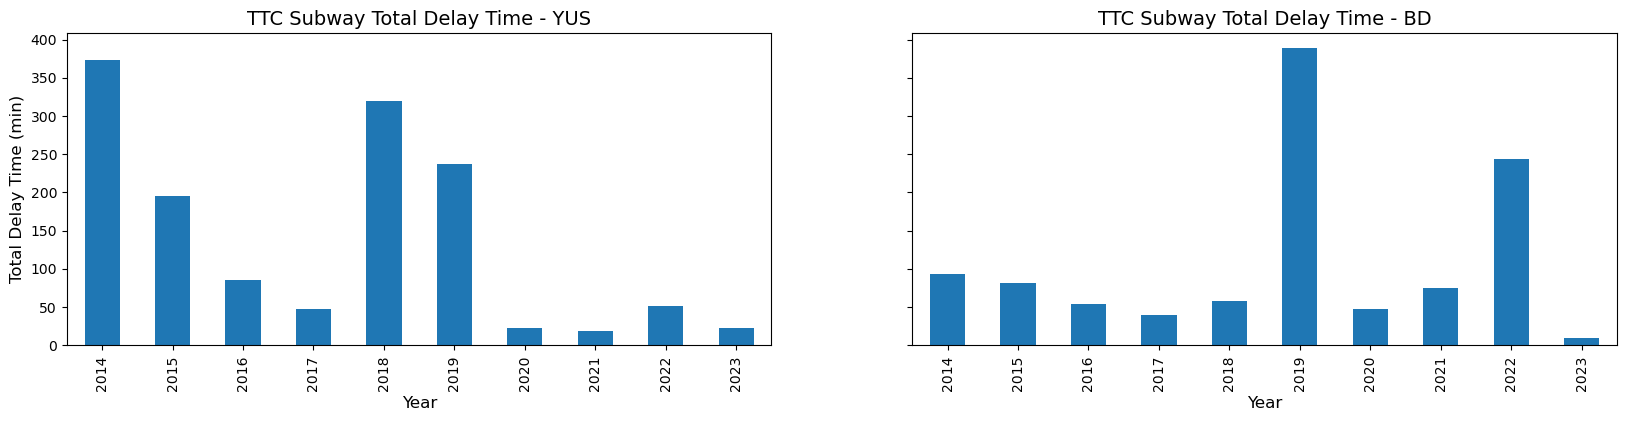

In [93]:
# Total delay minutes due to weather
fig, axs = plt.subplots(1, 2, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(2):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "MUWEA") | (real_delay["Code"] == "PUSIS") | (real_delay["Code"] == "MRWEA"))]    
    weather_delay_time_line = line.groupby(line.index.year)["Min Delay"].sum()
    weather_delay_time_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


In [94]:
real_delay[real_delay["Code"].isin(["PUOPO", "EUDO", "ERDO"])].groupby("Station")["Min Delay"].count().sort_values(ascending = False).head(10)

Station
HIGHWAY 407 STATION               199
SPADINA YUS STATION               131
YORKDALE STATION                  125
SHEPPARD - YONGE STATION - YUS    108
ST GEORGE YUS STATION             105
LAWRENCE EAST STATION             105
LESLIE STATION                    104
WILSON STATION                    102
KENNEDY SRT STATION                99
KENNEDY BD STATION                 98
Name: Min Delay, dtype: int64

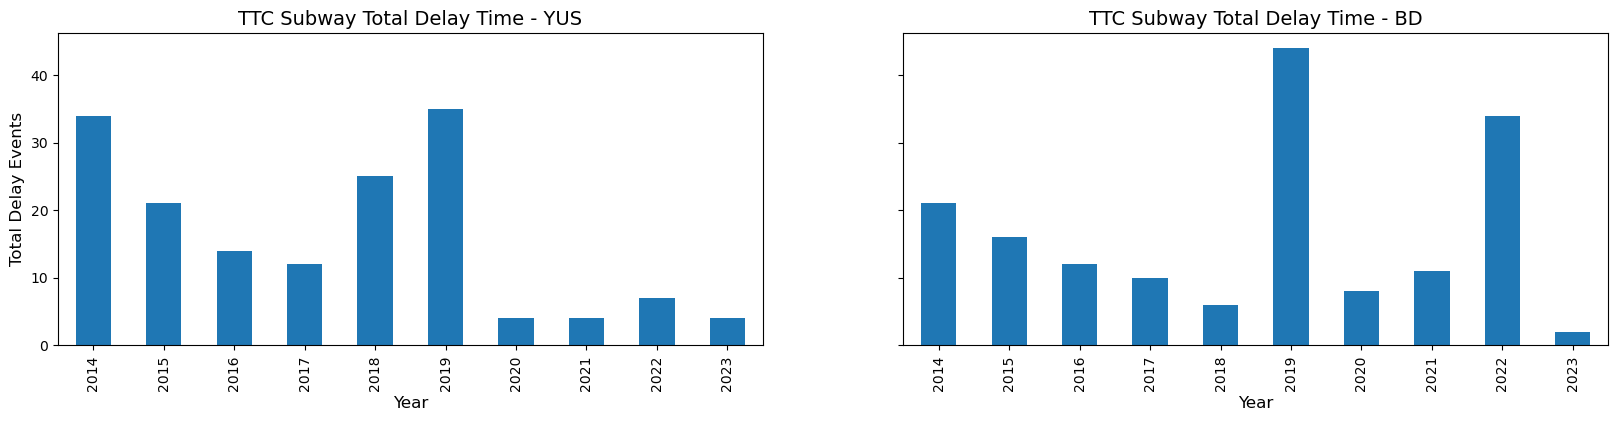

In [95]:
# Total delay events due to weather
fig, axs = plt.subplots(1, 2, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(2):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "MUWEA") | (real_delay["Code"] == "PUSIS") | (real_delay["Code"] == "MRWEA"))]    
    weather_delay_count_line = line.groupby(line.index.year)["Min Delay"].count()
    weather_delay_count_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


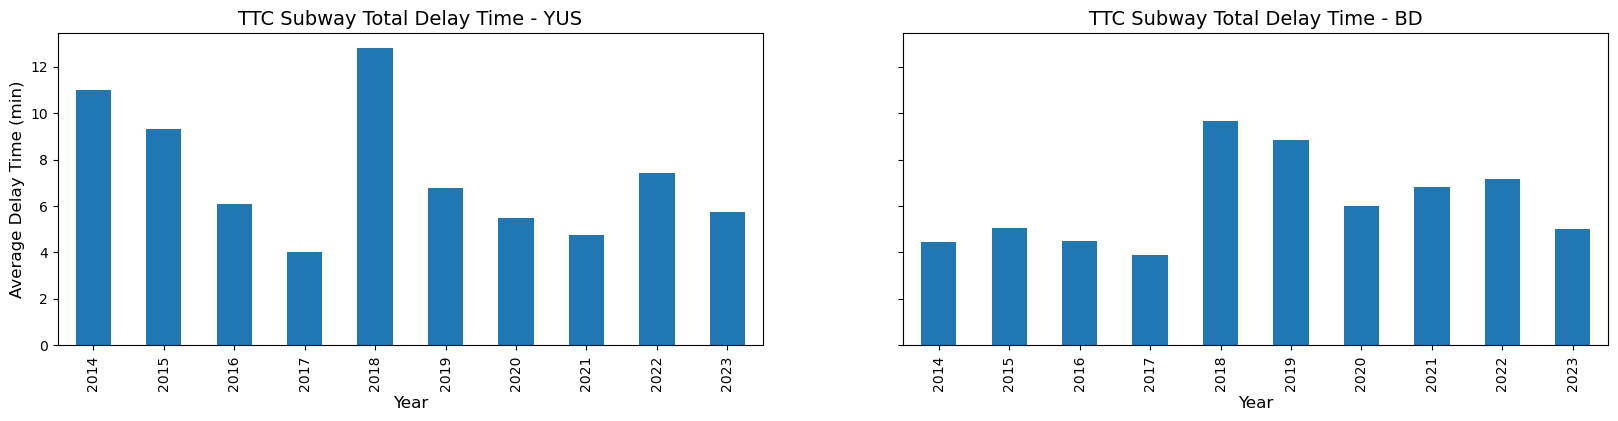

In [96]:
# Total delay events due to weather
fig, axs = plt.subplots(1, 2, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(2):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "MUWEA") | (real_delay["Code"] == "PUSIS") | (real_delay["Code"] == "MRWEA"))]    
    weather_delay_line = line.groupby(line.index.year)["Min Delay"].sum()/line.groupby(line.index.year)["Min Delay"].count()
    weather_delay_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Average Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()
